In [602]:
from polygraphs.analysis import Processor
import dgl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import binomtest
from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import mcnemar
from pprint import pprint

# Test null hyposthesis: There is no statistically significant difference in average steps till convergence between networks w/ shuffled evidence order and networks w/ static, arbitrary evidence order


## Loading data

In [321]:
x = Processor("shuffle_test")
x.add_config("network.groups", "mistrust", "network.selfloop", "seed")


In [323]:
shuffle_diff_raw = x.get()

# Discarding all simulations that did not converge before step 10000
# I want to run calculations on distribution, and I know that there is an arbitrarily high amount of sims at 10,000 steps
shuffle_diff = shuffle_diff_raw[shuffle_diff_raw['steps'] != 10000]

# Difference of new index and original index to check how many sims were cut short at 10000
shuffle_diff.reset_index().tail()


,index,bin_file_path,hd5_file_path,config_json_path,trials,network_size,network_kind,op,epsilon,steps,duration,action,undefined,converged,polarized,network_groups,mistrust,network_selfloop,seed
1340,1594,shuffle_test/EI-self_loop-shuffled-64-3-0.5-12...,shuffle_test/EI-self_loop-shuffled-64-3-0.5-12...,shuffle_test/EI-self_loop-shuffled-64-3-0.5-12...,10.0,64.0,complete_grouped,EpistemicInjusticeOp_Shuffled,0.001,2878.0,6.837636,B,False,True,False,3,0.50,True,12023
1341,1595,shuffle_test/EI-self_loop-64-3-0.5-12052/1.bin,shuffle_test/EI-self_loop-64-3-0.5-12052/1.hd5,shuffle_test/EI-self_loop-64-3-0.5-12052/confi...,10.0,64.0,complete_grouped,EpistemicInjusticeOp,0.001,1517.0,3.588787,B,False,True,False,3,0.50,True,12052
1342,1596,shuffle_test/EI-self_loop-64-3-0.75-12054/1.bin,shuffle_test/EI-self_loop-64-3-0.75-12054/1.hd5,shuffle_test/EI-self_loop-64-3-0.75-12054/conf...,10.0,64.0,complete_grouped,EpistemicInjusticeOp,0.001,989.0,2.432236,B,False,True,False,3,0.75,True,12054
1343,1597,shuffle_test/EI-self_loop-shuffled-16-2-0.5-12...,shuffle_test/EI-self_loop-shuffled-16-2-0.5-12...,shuffle_test/EI-self_loop-shuffled-16-2-0.5-12...,10.0,16.0,complete_grouped,EpistemicInjusticeOp_Shuffled,0.001,9492.0,18.623524,B,False,True,False,2,0.50,True,12045
1344,1598,shuffle_test/EI-self_loop-shuffled-16-2-0.75-1...,shuffle_test/EI-self_loop-shuffled-16-2-0.75-1...,shuffle_test/EI-self_loop-shuffled-16-2-0.75-1...,10.0,16.0,complete_grouped,EpistemicInjusticeOp_Shuffled,0.001,4529.0,8.724192,B,False,True,False,2,0.75,True,12079


In [324]:
# Group by 'op' and calculate the mean of the 'steps' column
average_steps_per_op = shuffle_diff.groupby('op')['steps'].mean().reset_index()

# Rename the 'steps' column to something more descriptive if needed
average_steps_per_op.rename(columns={'steps': 'average_steps'}, inplace=True)

average_steps_per_op

,op,average_steps
0,EpistemicInjusticeOp,4116.386330
1,EpistemicInjusticeOp_Shuffled,4124.715774


In [325]:
# Calculate the standard deviation of 'steps' for each 'op'
steps_std_by_op = shuffle_diff.groupby('op')['steps'].std().reset_index()

# Rename
steps_std_by_op.rename(columns={'steps': 'steps_std'}, inplace=True)

steps_std_by_op

,op,steps_std
0,EpistemicInjusticeOp,2556.742085
1,EpistemicInjusticeOp_Shuffled,2567.354061


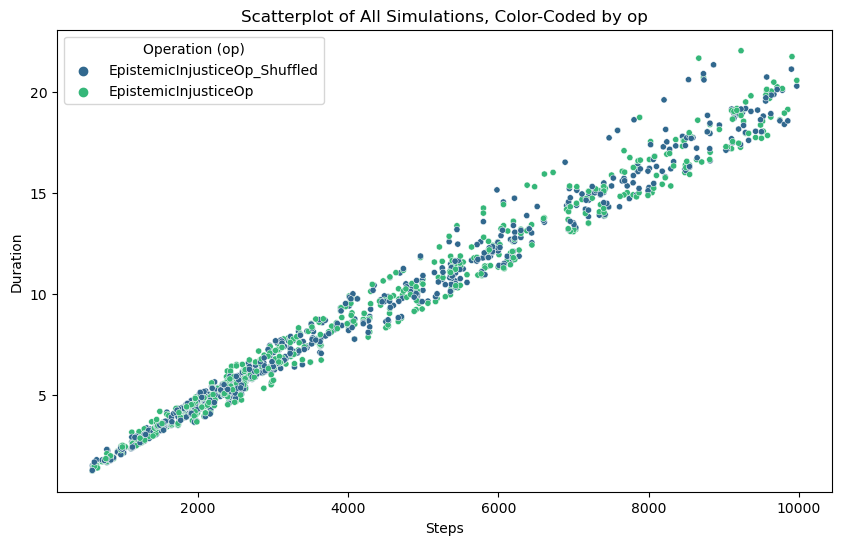

In [326]:
# Set up the plot
plt.figure(figsize=(10, 6))

# Create a scatterplot using seaborn, color-coding by 'op'
sns.scatterplot(data=shuffle_diff, x='steps', y='duration', hue='op', palette='viridis', s=20)

# Add titles and labels
plt.title('Scatterplot of All Simulations, Color-Coded by op')
plt.xlabel('Steps')
plt.ylabel('Duration')

# Show the plot
plt.legend(title='Operation (op)')
plt.show()

/Users/shahin/anaconda3/envs/polygraphs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='steps', ylabel='Count'>

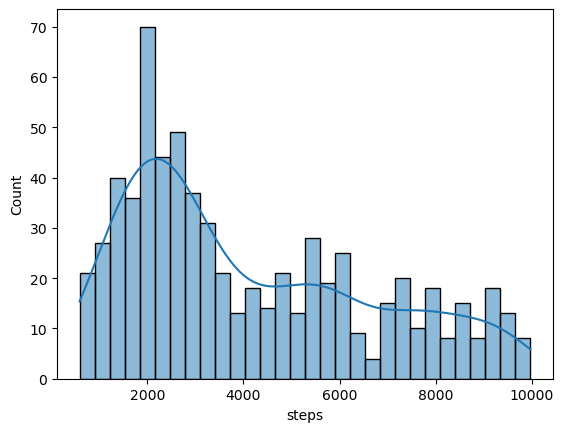

In [327]:
sns.histplot(EpistemicInjusticeOp_df, kde=True, bins=30)

### Doesn't look normal!

## Confirming data is not normal

In [329]:
# Running Kolmogorov-Smirnov Test
# Null Hypothesis: The sample data comes from a normal distribution.

stat, p_value = kstest(shuffle_diff['steps'].dropna(), 'norm')
print(p_value)



0.0


Kolmogorov-Smirnov test gives maximum doubt regarding normality of data

/Users/shahin/anaconda3/envs/polygraphs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


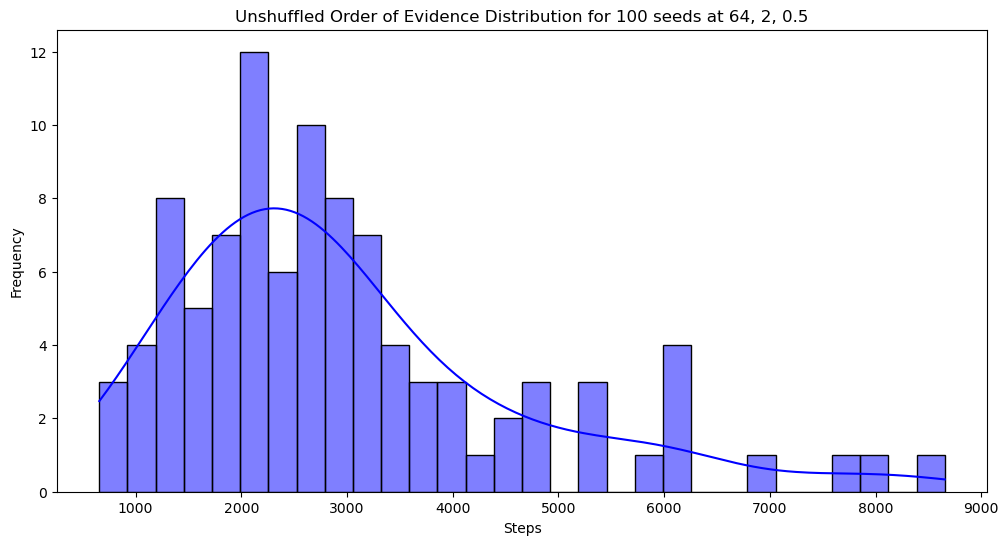

/Users/shahin/anaconda3/envs/polygraphs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


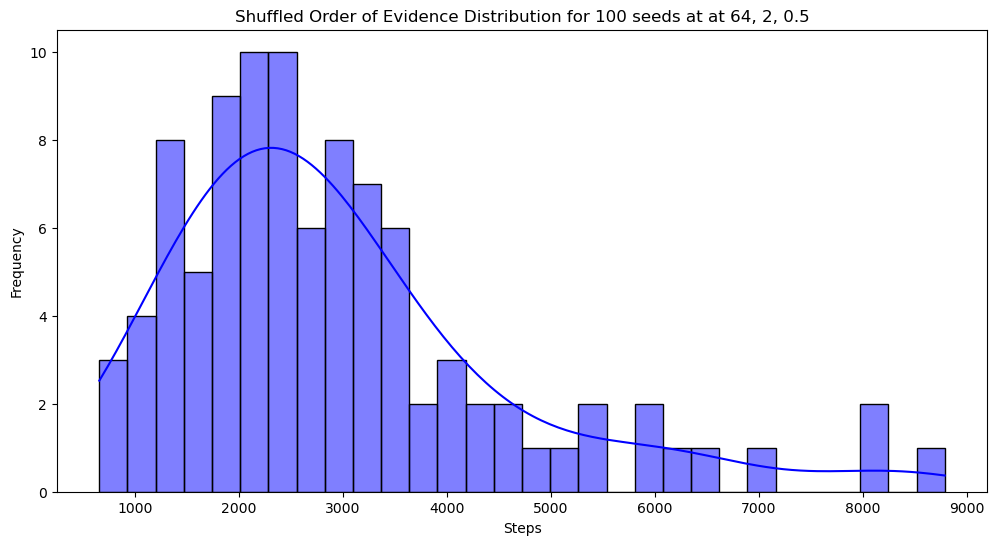

In [332]:
# Checking normality for distribution of one paramater setting: size 64, 2 groups, 0.5 certainty in case of prejudice
# Perhaps the data is showing up as none normal because I have many different simulation cases in my df

case_df = shuffle_diff[
    (shuffle_diff['network_size'] == 64) &
    (shuffle_diff['network_groups'] == 2) &
    (shuffle_diff['mistrust'] == 0.5)
]

# Separate by operation
single_case_df_unshuffled = case_df[case_df['op'] == 'EpistemicInjusticeOp']['steps']
single_case_df_shuffled = case_df[case_df['op'] == 'EpistemicInjusticeOp_Shuffled']['steps']

df_list = [single_case_df_unshuffled, single_case_df_shuffled]
df_names = ["Unshuffled Order of Evidence Distribution for 100 seeds at 64, 2, 0.5", "Shuffled Order of Evidence Distribution for 100 seeds at at 64, 2, 0.5"]

# Iterate over DataFrames and their corresponding names
for df, name in zip(df_list, df_names):
    # Create a new figure
    plt.figure(figsize=(12, 6))
    
    # Histogram using seaborn
    sns.histplot(df.dropna(), bins=30, kde=True, color='blue')
    
    # Title and labels
    plt.title(name)
    plt.xlabel('Steps')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()


## Paired sample test for non normally-distributed, dependent data

In [331]:
#Confirming there is a pair per seed (one from shuffled order, one from unshuffled order)

# Define the range of seed values to check
seed_range = range(12000, 12101)


# Group by 'seed' and count the number of rows per seed
seed_counts = case_df.groupby('seed').size()

# Check each seed and print a confirmation message
for seed in seed_range:
    if seed in seed_counts.index:
        count = seed_counts[seed]
        if count == 2:
            continue
        else:
            print(f"Seed {seed}: Incorrect number of rows ({count})")
    else:
        print(f"Seed {seed}: No rows found")

Seed 12018: No rows found
Seed 12049: No rows found
Seed 12069: Incorrect number of rows (1)
Seed 12100: No rows found


In [310]:
# Dropping seed 12069 because it doesn't have a pair for paired sample test
# (1/2 the pair was discarded when removing un-converged sims. This means that, in one case, evidence order pushed the steps needed over or under 10000)
paired_df = case_df[case_df['seed'] != 12069]

# Dropping unneeded columns

columns = ['op', 'seed', 'steps']
filtered_paired_df = paired_df[columns]


df1 = filtered_paired_df[filtered_paired_df['op'] == 'EpistemicInjusticeOp']
df2 = filtered_paired_df[filtered_paired_df['op'] == 'EpistemicInjusticeOp_Shuffled']

# Merging on seed
merged_df = pd.merge(df1, df2, on='seed', suffixes=('_unshuffled', '_shuffled'))

std_df = merged_df[['seed', 'steps_unshuffled', 'steps_shuffled']]

std_df.tail()

,seed,steps_unshuffled,steps_shuffled
92,12040,2198.0,2198.0
93,12014,1398.0,1398.0
94,12013,2142.0,2146.0
95,12025,3627.0,3634.0
96,12022,2934.0,2933.0


In [306]:

# Wilcoxon signed-rank test for non-normally distributed, paired, dependent samples:
# Continuous data that fails to satisfy assumptions for a parametric test is tested as though ordinal
# https://www.youtube.com/watch?v=dYJLUvo0Q6g

w_stat, p_value_wilcoxon = stats.wilcoxon(std_df['steps_unshuffled'], std_df['steps_shuffled'])

print(f'Wilcoxon signed-rank test: W-statistic={w_stat}, p-value={p_value_wilcoxon}')



Wilcoxon signed-rank test: W-statistic=146.5, p-value=0.666753407428196


Wilcoxon signed-rank test fails to disprove null hypothesis. The p-value indicates there is high certainty that the difference pre and post-shuffle is not significant.
However, the test assumes symmetry of distribution regarding the differences between each sample and its pair.

### Checking symmetry of difference distribution

<Axes: >

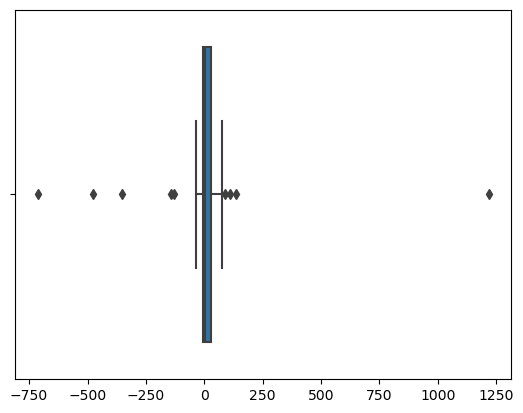

In [199]:
std_df_diff = std_df['steps_unshuffled'] - std_df['steps_shuffled']

# Dropping zeroes because they break the boxplot 
# (most of the pairs have no difference)
std_df_no_zeros = std_df_diff[std_df_diff != 0]

sns.boxplot(x=std_df_no_zeros)

The box plot isn't super clear, and I'm ignoring the 0's. Trying a histogram, instead, with all the data.

/Users/shahin/anaconda3/envs/polygraphs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

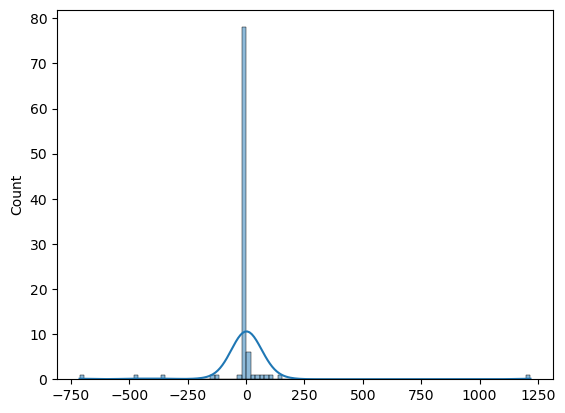

In [210]:
sns.histplot(x=std_df_diff, bins=100, kde=True)

The distribution of the differences is symmetrical, verifying the assumption of the Wilcoxon signed-rank test

## Same Calculations for all configs instead of one case (converged samples only)

In [355]:
groupbyop = shuffle_diff.groupby(['op', 'seed'])['steps'].mean().reset_index()

seed_counts = groupbyop.groupby('seed').size()

# Check each seed and print a confirmation message
for seed in seed_range:
    if seed in seed_counts.index:
        count = seed_counts[seed]
        if count == 2:
            continue
        else:
            print(f"Seed {seed}: Incorrect number of rows ({count})")
    else:
        print(f"Seed {seed}: No rows found")

Seed 12100: No rows found


In [371]:
# Dropping unneeded columns

columns = ['op', 'seed', 'steps']
filtered_all_cases = groupbyop[columns]


df1_all = filtered_all_cases[filtered_all_cases['op'] == 'EpistemicInjusticeOp']
df2_all = filtered_all_cases[filtered_all_cases['op'] == 'EpistemicInjusticeOp_Shuffled']

# Merging on seed
merged_df_all = pd.merge(df1_all, df2_all, on='seed', suffixes=('_unshuffled', '_shuffled'))

merged_df_filtered = merged_df_all[['seed', 'steps_unshuffled', 'steps_shuffled']]

merged_df_filtered.head()

,seed,steps_unshuffled,steps_shuffled
0,12000,7453.875,7517.25
1,12001,2019.000,2019.00
2,12002,3949.500,3961.25
3,12003,2173.250,2151.75
4,12004,2798.250,2798.25


Wilcoxon signed-rank test: W-statistic=803.0, p-value=0.5359394911343949


/Users/shahin/anaconda3/envs/polygraphs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

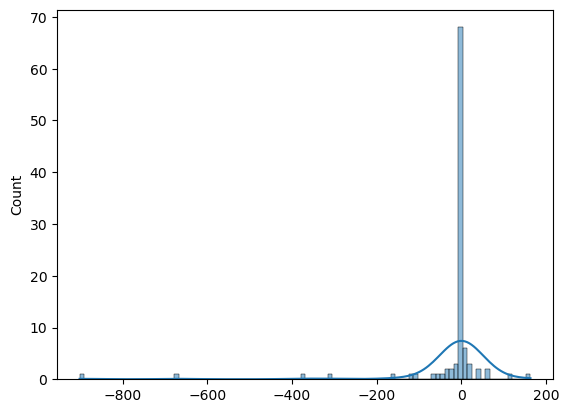

In [374]:
# Wilcoxon Signed-Rank Test for all sims
w_stat, p_value_wilcoxon = stats.wilcoxon(merged_df_filtered['steps_unshuffled'], merged_df_filtered['steps_shuffled'])

print(f'Wilcoxon signed-rank test: W-statistic={w_stat}, p-value={p_value_wilcoxon}')

all_diff_shuffle = merged_df_filtered['steps_unshuffled'] - merged_df_filtered['steps_shuffled']

sns.histplot(x=all_diff_shuffle, bins=100, kde=True)


Here we see that the difference between pairs fails to satisfy the symmetrical assumption of the Wilcoxon signed-rank test. 
Therefore, I will perform a sign test, which makes no such assumption.

In [498]:
#Source for sign test:
#https://vitalflux.com/sign-test-hypothesis-python-examples/

# Calculate the number of positive and negative differences
n_pos = np.sum(all_diff_shuffle > 0)
n_neg = np.sum(all_diff_shuffle < 0)
 
# We use the smaller of n_pos and n_neg as our test statistic (for a two-tailed test)
n = np.min([n_pos, n_neg])
 
# Calculate p-value (two-tailed) using the binomial test
binom_results = stats.binomtest(n, n=n_pos + n_neg, alternative='two-sided')
 
print(binom_results)

BinomTestResult(k=29, n=59, alternative='two-sided', statistic=0.4915254237288136, pvalue=1.0)


P-value strongly indicates we cannot reject the null hypothesis

# Re-loading Data for Analysis on Epistemic Injustice
I'm just loading the unshuffled data. It shouldn't really matter which I choose, but I don't need pairs at each seed + parameter setting.
There are 100 sims (seeds) at each of 8 settings.


In [503]:
x = Processor("data")
x.add_config("network.groups", "mistrust", "seed")

df = x.get()

df_converged = df[df['action'] != '?']
# about 16% of simulations did not converge by step 10000

df_converged.head()


,bin_file_path,hd5_file_path,config_json_path,trials,network_size,network_kind,op,epsilon,steps,duration,action,undefined,converged,polarized,network_groups,mistrust,seed
1,data/EI-self_loop-16-2-0.5-12070/1.bin,data/EI-self_loop-16-2-0.5-12070/1.hd5,data/EI-self_loop-16-2-0.5-12070/configuration...,10.0,16.0,complete_grouped,EpistemicInjusticeOp,0.001,5182.0,9.776982,B,False,True,False,2,0.50,12070
2,data/EI-self_loop-64-3-0.5-12029/1.bin,data/EI-self_loop-64-3-0.5-12029/1.hd5,data/EI-self_loop-64-3-0.5-12029/configuration...,10.0,64.0,complete_grouped,EpistemicInjusticeOp,0.001,1780.0,4.188188,B,False,True,False,3,0.50,12029
4,data/EI-self_loop-64-3-0.75-12010/1.bin,data/EI-self_loop-64-3-0.75-12010/1.hd5,data/EI-self_loop-64-3-0.75-12010/configuratio...,10.0,64.0,complete_grouped,EpistemicInjusticeOp,0.001,2377.0,5.908375,B,False,True,False,3,0.75,12010
5,data/EI-self_loop-64-3-0.5-12016/1.bin,data/EI-self_loop-64-3-0.5-12016/1.hd5,data/EI-self_loop-64-3-0.5-12016/configuration...,10.0,64.0,complete_grouped,EpistemicInjusticeOp,0.001,7587.0,18.094811,B,False,True,False,3,0.50,12016
6,data/EI-self_loop-64-3-0.75-12028/1.bin,data/EI-self_loop-64-3-0.75-12028/1.hd5,data/EI-self_loop-64-3-0.75-12028/configuratio...,10.0,64.0,complete_grouped,EpistemicInjusticeOp,0.001,1365.0,3.261279,B,False,True,False,3,0.75,12028


In [504]:
grouped_converged = df_converged.groupby(['network_size', 'network_groups', 'mistrust'])
mean_steps_converged = grouped_converged['steps'].mean()
mean_steps_df_converged = mean_steps_converged.reset_index(name='mean_steps_converged')
mean_steps_df_converged

,network_size,network_groups,mistrust,mean_steps_converged
0,16.0,2,0.50,6480.285714
1,16.0,2,0.75,6074.506849
2,16.0,3,0.50,6201.014085
3,16.0,3,0.75,5833.906667
4,64.0,2,0.50,2981.775510
5,64.0,2,0.75,2508.734694
6,64.0,3,0.50,2608.391753
7,64.0,3,0.75,2548.285714


In [506]:
# Groupby each configuration
grouped_by_config = df.groupby(['network_size', 'network_groups', 'mistrust'])

# Grab number of times each action occured by config
action_counts = grouped_by_config['action'].value_counts().unstack(fill_value=0).reset_index()

# Grab proportion of converged to truth : all sims
action_counts['Converged_T_/_total'] = action_counts['B'] / (action_counts['A'] + action_counts['B'] + action_counts['?'])

# Grab proportion of converged to truth : converged
action_counts['Converged_T_/_converged'] = action_counts['B'] / (action_counts['A'] + action_counts['B'])

action_counts

action,network_size,network_groups,mistrust,?,A,B,Converged_T_/_total,Converged_T_/_converged
0,16.0,2,0.50,37,3,60,0.60,0.952381
1,16.0,2,0.75,27,1,72,0.72,0.986301
2,16.0,3,0.50,29,2,69,0.69,0.971831
3,16.0,3,0.75,25,2,73,0.73,0.973333
4,64.0,2,0.50,2,1,97,0.97,0.989796
5,64.0,2,0.75,2,1,97,0.97,0.989796
6,64.0,3,0.50,3,1,96,0.96,0.989691
7,64.0,3,0.75,2,1,97,0.97,0.989796


In [507]:
# Grabbing mean steps by config for all sims, and again, separately, for only those sims that converged
mean_steps_total = grouped_by_config['steps'].mean()
mean_steps_total_df = mean_steps_total.reset_index(name='mean_steps_total')
mergd_ = pd.merge(action_counts, mean_steps_total_df, on=['network_size', 'network_groups', 'mistrust'])
merged_df = pd.merge(mergd_, mean_steps_df_converged, on=['network_size', 'network_groups', 'mistrust'])

merged_df

,network_size,network_groups,mistrust,?,A,B,Converged_T_/_total,Converged_T_/_converged,mean_steps_total,mean_steps_converged
0,16.0,2,0.50,37,3,60,0.60,0.952381,7782.58,6480.285714
1,16.0,2,0.75,27,1,72,0.72,0.986301,7134.39,6074.506849
2,16.0,3,0.50,29,2,69,0.69,0.971831,7302.72,6201.014085
3,16.0,3,0.75,25,2,73,0.73,0.973333,6875.43,5833.906667
4,64.0,2,0.50,2,1,97,0.97,0.989796,3122.14,2981.775510
5,64.0,2,0.75,2,1,97,0.97,0.989796,2658.56,2508.734694
6,64.0,3,0.50,3,1,96,0.96,0.989691,2830.14,2608.391753
7,64.0,3,0.75,2,1,97,0.97,0.989796,2697.32,2548.285714


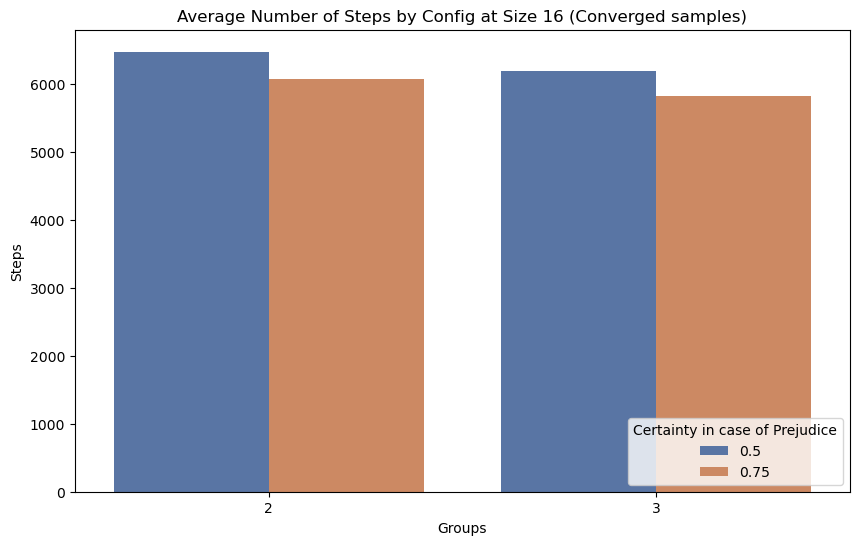

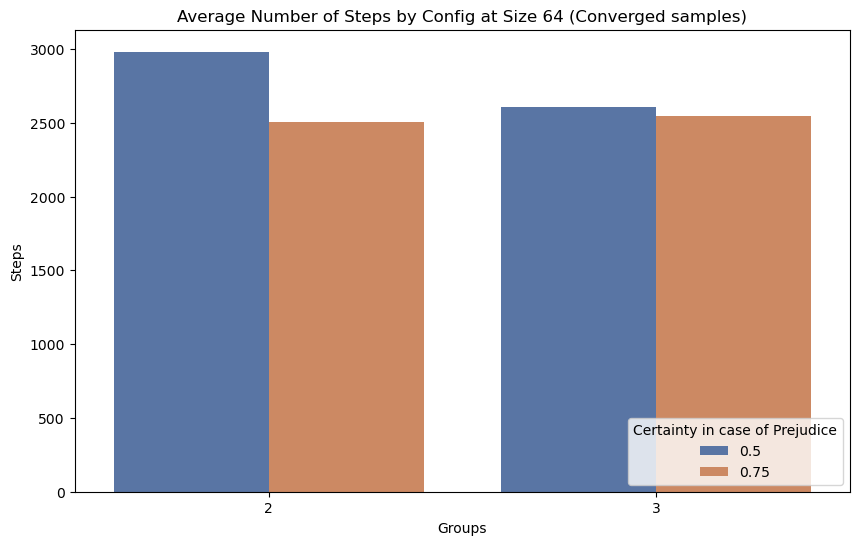

In [533]:
# Visualizing average steps for those sims that converged by config

# Filter data for network size 16
df_16 = mean_steps_df_converged[mean_steps_df_converged['network_size'] == 16.0]

# Filter data for network size 64
df_64 = mean_steps_df_converged[mean_steps_df_converged['network_size'] == 64.0]

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='network_groups', y='mean_steps_converged', hue='mistrust', data=df_16, palette='deep')


plt.title('Average Number of Steps by Config at Size 16 (Converged samples)')
plt.ylabel('Steps')
plt.xlabel('Groups')
plt.legend(title='Certainty in case of Prejudice', loc='lower right')
plt.show()

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='network_groups', y='mean_steps_converged', hue='mistrust', data=df_64, palette='deep')


plt.title('Average Number of Steps by Config at Size 64 (Converged samples)')
plt.ylabel('Steps')
plt.xlabel('Groups')
plt.legend(title='Certainty in case of Prejudice', loc='lower right')
plt.show()

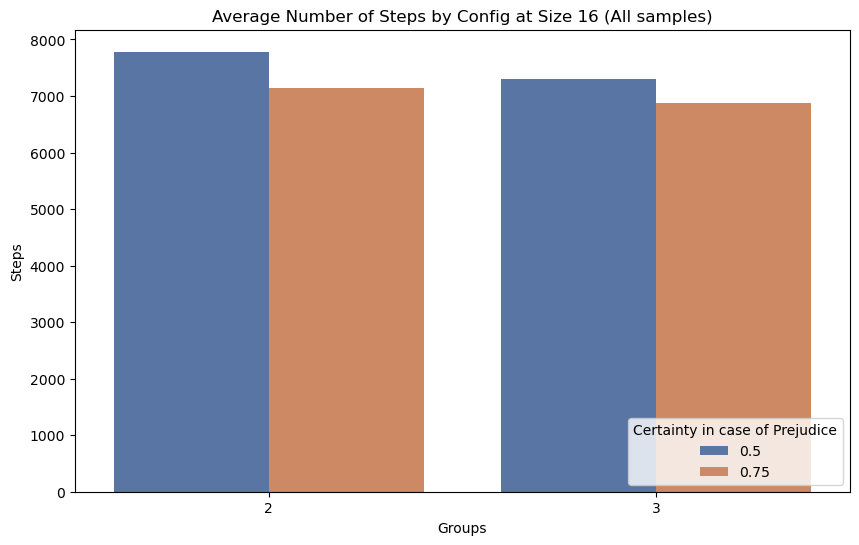

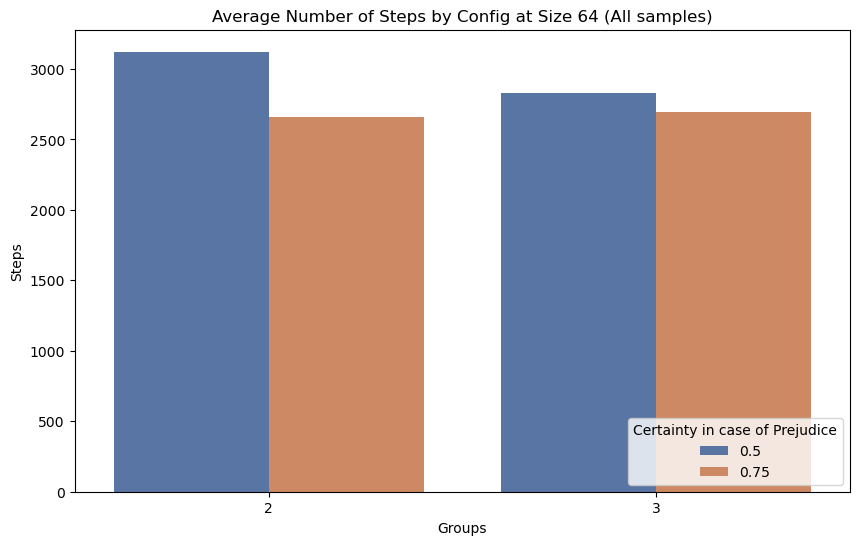

In [534]:
# Visualizing average steps for all sims by config

# Filter data for network size 16
df_16 = merged_df[merged_df['network_size'] == 16.0]

# Filter data for network size 64
df_64 = merged_df[merged_df['network_size'] == 64.0]

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='network_groups', y='mean_steps_total', hue='mistrust', data=df_16, palette='deep')


plt.title('Average Number of Steps by Config at Size 16 (All samples)')
plt.ylabel('Steps')
plt.xlabel('Groups')
plt.legend(title='Certainty in case of Prejudice', loc='lower right')
plt.show()

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='network_groups', y='mean_steps_total', hue='mistrust', data=df_64, palette='deep')


plt.title('Average Number of Steps by Config at Size 64 (All samples)')
plt.ylabel('Steps')
plt.xlabel('Groups')
plt.legend(title='Certainty in case of Prejudice', loc='lower right')
plt.show()

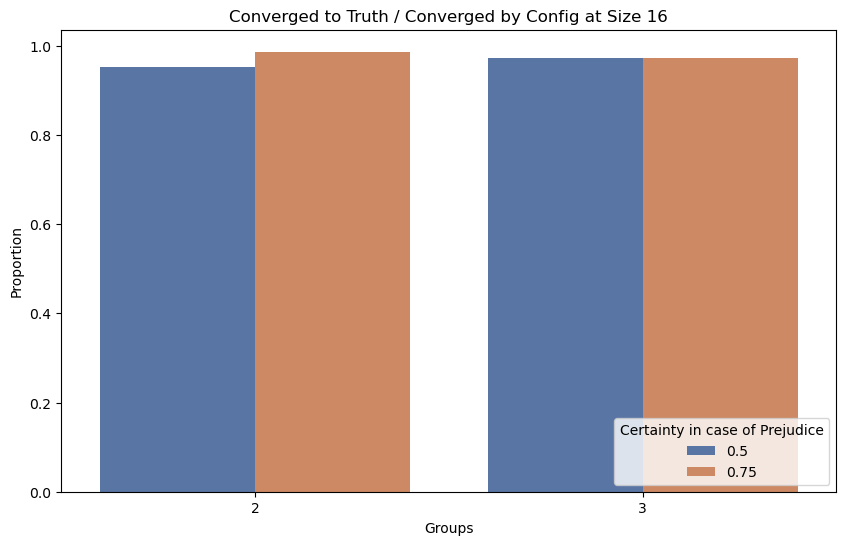

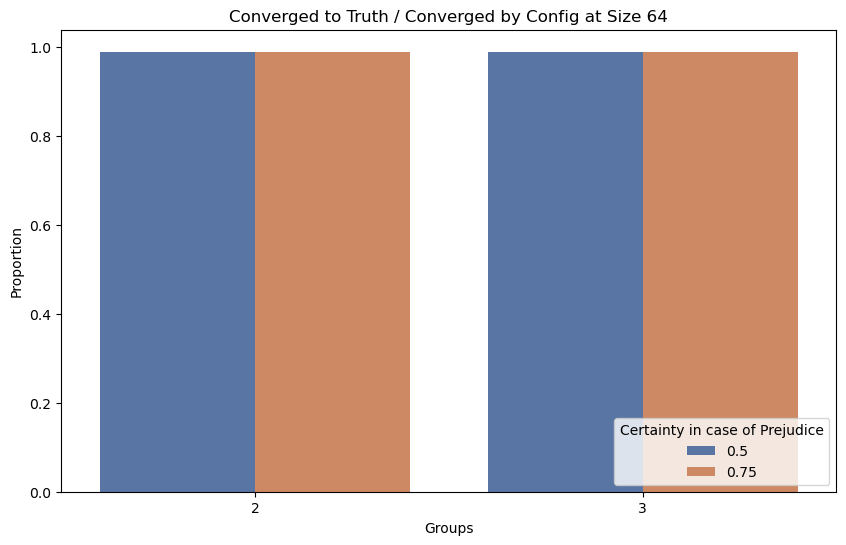

In [535]:
# Visualizing proportion of sims that converged to truth / sims that converged by config

# Filter data for network size 16
df_16 = merged_df[merged_df['network_size'] == 16.0]

# Filter data for network size 64
df_64 = merged_df[merged_df['network_size'] == 64.0]

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='network_groups', y='Converged_T_/_converged', hue='mistrust', data=df_16, palette='deep')


plt.title('Converged to Truth / Converged by Config at Size 16')
plt.ylabel('Proportion')
plt.xlabel('Groups')
plt.legend(title='Certainty in case of Prejudice', loc='lower right')
plt.show()

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='network_groups', y='Converged_T_/_converged', hue='mistrust', data=df_64, palette='deep')


plt.title('Converged to Truth / Converged by Config at Size 64')
plt.ylabel('Proportion')
plt.xlabel('Groups')
plt.legend(title='Certainty in case of Prejudice', loc='lower right')
plt.show()

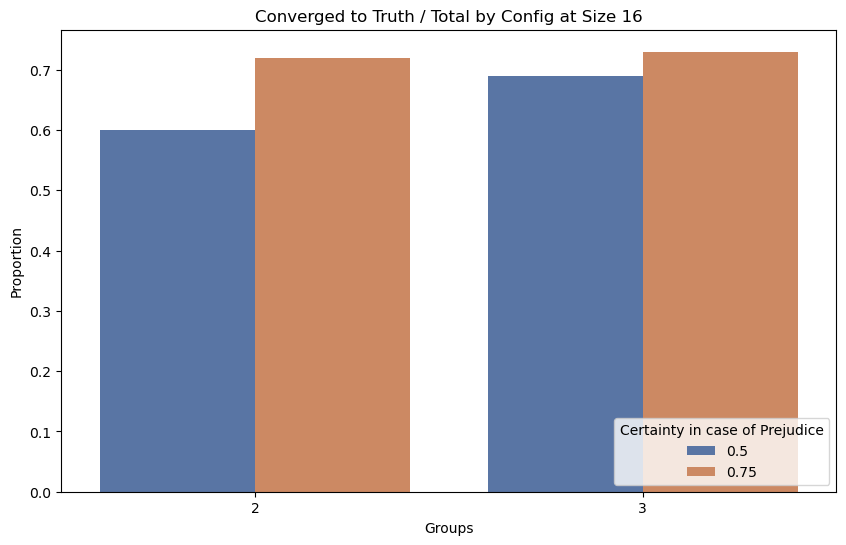

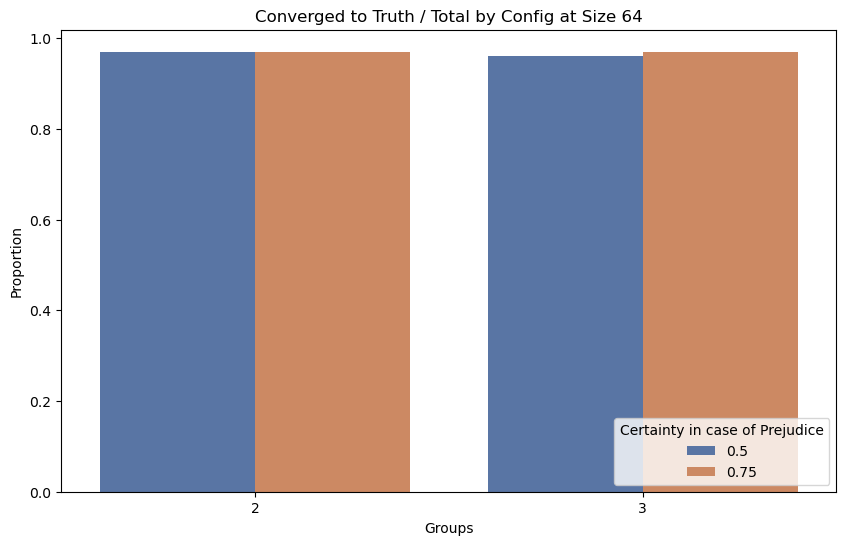

In [536]:
# Visualizing proportion of sims that converged to truth / all sims, by config

# Filter data for network size 16
df_16 = merged_df[merged_df['network_size'] == 16.0]

# Filter data for network size 64
df_64 = merged_df[merged_df['network_size'] == 64.0]

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='network_groups', y='Converged_T_/_total', hue='mistrust', data=df_16, palette='deep')


plt.title('Converged to Truth / Total by Config at Size 16')
plt.ylabel('Proportion')
plt.xlabel('Groups')
plt.legend(title='Certainty in case of Prejudice', loc='lower right')
plt.show()

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='network_groups', y='Converged_T_/_total', hue='mistrust', data=df_64, palette='deep')


plt.title('Converged to Truth / Total by Config at Size 64')
plt.ylabel('Proportion')
plt.xlabel('Groups')
plt.legend(title='Certainty in case of Prejudice', loc='lower right')
plt.show()

In [530]:
## Steps by network action and network_size
grouped_by_action = df_converged.groupby(['action', 'network_size'])
steps_by_action = grouped_by_action['steps'].mean()
steps_by_action_df = steps_by_action.reset_index(name='mean_steps')

steps_by_action_df


,action,network_size,mean_steps
0,A,16.0,5182.375000
1,A,64.0,4910.000000
2,B,16.0,6160.777372
3,B,64.0,2638.697674


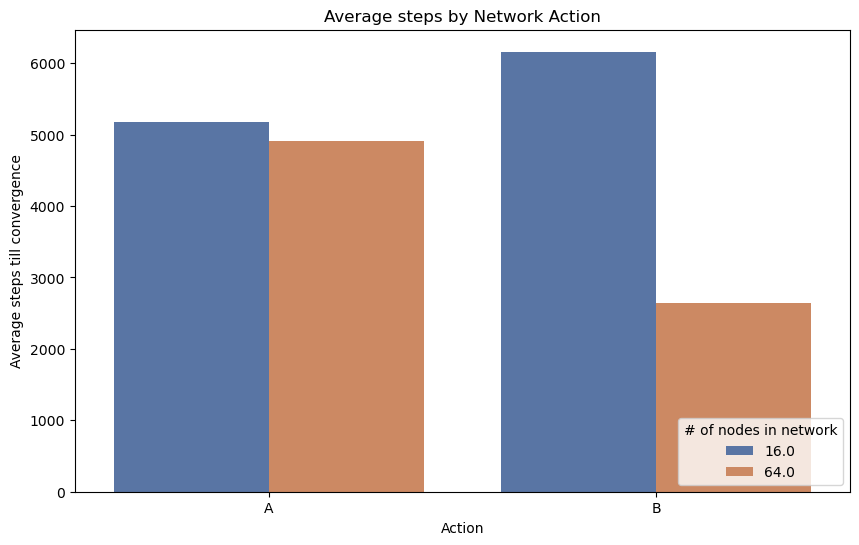

In [532]:
# Bar plot

plt.figure(figsize=(10, 6))
sns.barplot(x='action', y='mean_steps', hue='network_size', data=steps_by_action_df, palette='deep')


plt.title('Average steps by Network Action')
plt.ylabel('Average steps till convergence')
plt.xlabel('Action')
plt.legend(title='# of nodes in network', loc='lower right')
plt.show()

## Testing for change in proportion of convergence to truth after increasing prejudice amount


Intervention: Decreasing certainty at instances of prejudice

Null-Hypothesis: Decreasing certainty at instances of prejudice produces no statistically significant difference in network action


In [423]:
# Checking converged

df_converged_64 = df_converged[df_converged['network_size'] == 64]
df_converged_16 = df_converged[df_converged['network_size'] == 16]

columns = ['seed', 'action', 'mistrust']
filtered_df_converged_64 = df_converged_64[columns]
filtered_df_converged_16 = df_converged_16[columns]
 

pre_interv_64 = filtered_df_converged_64[filtered_df_converged_64['mistrust'] == 0.75]
post_interv_64 = filtered_df_converged_64[filtered_df_converged_64['mistrust'] == 0.5]

pre_interv_16 = filtered_df_converged_16[filtered_df_converged_16['mistrust'] == 0.75]
post_interv_16 = filtered_df_converged_16[filtered_df_converged_16['mistrust'] == 0.5]

# Merging on seed
merged_df_64 = pd.merge(pre_interv_64, post_interv_64, on='seed', suffixes=('_pre', '_post'))
merged_df_16 = pd.merge(pre_interv_16, post_interv_16, on='seed', suffixes=('_pre', '_post'))

merged_df_64_filtered = merged_df_64[['seed', 'action_pre', 'action_post']]
merged_df_16_filtered = merged_df_16[['seed', 'action_pre', 'action_post']]

print(merged_df_16_filtered[merged_df_16_filtered['action_pre'] == 'A'])
print(merged_df_16_filtered[merged_df_16_filtered['action_post'] == 'A'])
print(merged_df_64_filtered[merged_df_64_filtered['action_pre'] == 'A'])
print(merged_df_64_filtered[merged_df_64_filtered['action_post'] == 'A'])


      seed action_pre action_post
94   12042          A           A
95   12042          A           A
195  12042          A           A
196  12042          A           A
      seed action_pre action_post
94   12042          A           A
95   12042          A           A
195  12042          A           A
196  12042          A           A
      seed action_pre action_post
98   12039          A           A
99   12039          A           A
344  12039          A           A
345  12039          A           A
      seed action_pre action_post
98   12039          A           A
99   12039          A           A
344  12039          A           A
345  12039          A           A


I don't need ot run a test. Just by printing, I confirm that action remains the same across every sample pair at both network sizes and both group amounts. 

In [561]:
# Checking Total

# Splitting by nodes in network
df_64 = df[df['network_size'] == 64]
df_16 = df[df['network_size'] == 16]

columns_ = ['seed', 'action', 'mistrust', 'network_groups']
filtered_df_64 = df_64[columns_]
filtered_df_16 = df_16[columns_]

# Splitting by group
df_64_2 = filtered_df_64[filtered_df_64['network_groups'] == 2]
df_64_3 = filtered_df_64[filtered_df_64['network_groups'] == 3]

df_16_2 = filtered_df_16[filtered_df_16['network_groups'] == 2]
df_16_3 = filtered_df_16[filtered_df_16['network_groups'] == 3]

# Setting mistrust as intervention (pre = 0.75, post = 0.5)
pre_interv_64_2 = df_64_2[df_64_2['mistrust'] == 0.75].drop(columns=['network_groups', 'mistrust'])
post_interv_64_2 = df_64_2[df_64_2['mistrust'] == 0.5].drop(columns=['network_groups', 'mistrust'])

pre_interv_64_3 = df_64_3[df_64_3['mistrust'] == 0.75].drop(columns=['network_groups', 'mistrust'])
post_interv_64_3 = df_64_3[df_64_3['mistrust'] == 0.5].drop(columns=['network_groups', 'mistrust'])

pre_interv_16_2 = df_16_2[df_16_2['mistrust'] == 0.75].drop(columns=['network_groups', 'mistrust'])
post_interv_16_2 = df_16_2[df_16_2['mistrust'] == 0.5].drop(columns=['network_groups', 'mistrust'])

pre_interv_16_3 = df_16_3[df_16_3['mistrust'] == 0.75].drop(columns=['network_groups', 'mistrust'])
post_interv_16_3 = df_16_3[df_16_3['mistrust'] == 0.5].drop(columns=['network_groups', 'mistrust'])

# Merging on seed
merged_df_64_2 = pd.merge(pre_interv_64_2, post_interv_64_2, on='seed', suffixes=('_pre', '_post'))
merged_df_64_3 = pd.merge(pre_interv_64_3, post_interv_64_3, on='seed', suffixes=('_pre', '_post'))

merged_df_16_2 = pd.merge(pre_interv_16_2, post_interv_16_2, on='seed', suffixes=('_pre', '_post'))
merged_df_16_3 = pd.merge(pre_interv_16_3, post_interv_16_3, on='seed', suffixes=('_pre', '_post'))



# print all rows that dont have B as pre AND post 
# (outdated dfs from before splitting by group)

# print(merged_df_16_filtered[merged_df_16_filtered['action_pre'] == 'A'])
# print(merged_df_16_filtered[merged_df_16_filtered['action_post'] == 'A'])
# print(merged_df_64_filtered[merged_df_64_filtered['action_pre'] == 'A'])
# print(merged_df_64_filtered[merged_df_64_filtered['action_post'] == 'A'])

# print(merged_df_16_filtered[merged_df_16_filtered['action_pre'] == '?'])
# print(merged_df_16_filtered[merged_df_16_filtered['action_post'] == '?'])
# print(merged_df_64_filtered[merged_df_64_filtered['action_pre'] == '?'])
# print(merged_df_64_filtered[merged_df_64_filtered['action_post'] == '?'])

      seed action_pre action_post
150  12042          A           A
151  12042          A           A
272  12066          A           ?
273  12066          A           ?
310  12042          A           A
311  12042          A           A
      seed action_pre action_post
11   12095          ?           A
136  12047          ?           A
137  12047          ?           A
150  12042          A           A
151  12042          A           A
269  12095          ?           A
310  12042          A           A
311  12042          A           A
398  12047          ?           A
399  12047          ?           A
      seed action_pre action_post
102  12039          A           A
103  12039          A           A
356  12039          A           A
357  12039          A           A
      seed action_pre action_post
102  12039          A           A
103  12039          A           A
356  12039          A           A
357  12039          A           A
      seed action_pre action_post
0    12003    


At this point, I can say that increasing prejudice has no statistically significant effect on the network action of those sims that converged before step 10,000, but very clearly has greater effect when considering unconverged sims

There is no test for paired, nominal data with >2 possible outcomes for the dependent variable. 
Mcnemar assumes a dichotomous  dependent variable
Chi-2 disregards sample pairs, which means it does not control for initial conditions (Initial conditions are controlled by pairing pre and post intervention by seed!)

Therefore, I reduce the outcomes to a binary: Converged to truth and Not converged to truth
This allows the data to meet the assumptions of the mcnemar test

In [713]:
# Define a function to map outcomes to 'B' or 'not B'
def map_to_binary(df, pre, post):
    df['pre_mapped'] = df[pre].apply(lambda x: 'B' if x == 'B' else 'not B')
    df['post_mapped'] = df[post].apply(lambda x: 'B' if x == 'B' else 'not B')
    return df

# Pass each size/group combination into function
merged_df_16_2 = map_to_binary(merged_df_16_2, 'action_pre', 'action_post')
merged_df_16_3 = map_to_binary(merged_df_16_3, 'action_pre', 'action_post')
merged_df_64_2 = map_to_binary(merged_df_64_2, 'action_pre', 'action_post')
merged_df_64_3 = map_to_binary(merged_df_64_3, 'action_pre', 'action_post')

merged_df_16_2.head()


,seed,action_pre,action_post,pre_mapped,post_mapped
0,12003,?,?,not B,not B
1,12004,?,?,not B,not B
2,12032,B,B,B,B
3,12035,?,?,not B,not B
4,12061,?,?,not B,not B


In [590]:

dataframes = {
    '16_2': merged_df_16_2,
    '16_3': merged_df_16_3,
    '64_2': merged_df_64_2,
    '64_3': merged_df_64_3
}

# Define function to calculate values for a contingency table based on condition (separate counts for each possible pre/post combination)
# https://www.youtube.com/watch?v=ax265c6pqvA
def count_combinations(df): 
    a = ((df['pre_mapped'] == 'B') & (df['post_mapped'] == 'B')).sum()
    b = ((df['pre_mapped'] == 'B') & (df['post_mapped'] == 'not B')).sum()
    c = ((df['pre_mapped'] == 'not B') & (df['post_mapped'] == 'B')).sum()
    d = ((df['pre_mapped'] == 'not B') & (df['post_mapped'] == 'not B')).sum()
    return a, b, c, d

# Loop through each dataframe, calculate counts, and print results
for name, df in dataframes.items():
    # Count occurrences
    a, b, c, d = count_combinations(df)

    # Create and print contingency table
    contingency_table = pd.DataFrame({
        'Post B': [a, c],
        'Post not B': [b, d]
    }, index=['Pre B', 'Pre not B'])

    print(f"Contingency Table for {name}:\n{contingency_table}\n")

    # Perform McNemar test
    result = mcnemar([[d, b], [c, a]])
    print(f"McNemar Test Result for {name}:")
    print(f"Statistic: {result.statistic}, p-value: {result.pvalue}\n")

Contingency Table for 16_2:
           Post B  Post not B
Pre B          60          12
Pre not B       0          28

McNemar Test Result for 16_2:
Statistic: 0.0, p-value: 0.00048828125

Contingency Table for 16_3:
           Post B  Post not B
Pre B          68           5
Pre not B       1          26

McNemar Test Result for 16_3:
Statistic: 1.0, p-value: 0.21875

Contingency Table for 64_2:
           Post B  Post not B
Pre B          96           1
Pre not B       1           2

McNemar Test Result for 64_2:
Statistic: 1.0, p-value: 1.0

Contingency Table for 64_3:
           Post B  Post not B
Pre B          95           2
Pre not B       1           2

McNemar Test Result for 64_3:
Statistic: 1.0, p-value: 1.0



## Testing for difference by groups

Intervention: Increasing the proportion of prejudiced nodes in the network (removing neutral group)

Null-Hypothesis: Increasing the proportion of prejudiced nodes in the network produces no statistically significant difference in proportion of nodes that converge to truth

In [599]:
# Running the same code as before, but swapping the roles of 'mistrust' and 'groups'

# Splitting by certainty in case of prejudice
df_64_dot5 = filtered_df_64[filtered_df_64['mistrust'] == 0.5]
df_64_dot75 = filtered_df_64[filtered_df_64['mistrust'] == 0.75]

df_16_dot5 = filtered_df_16[filtered_df_16['mistrust'] == 0.5]
df_16_dot75 = filtered_df_16[filtered_df_16['mistrust'] == 0.75]


# Setting number of groups as intervention (pre = 3, post = 2)
pre_interv_64_dot5 = df_64_dot5[df_64_dot5['network_groups'] == 3].drop(columns=['network_groups', 'mistrust'])
post_interv_64_dot5 = df_64_dot5[df_64_dot5['network_groups'] == 2].drop(columns=['network_groups', 'mistrust'])

pre_interv_64_dot75 = df_64_dot75[df_64_dot75['network_groups'] == 3].drop(columns=['network_groups', 'mistrust'])
post_interv_64_dot75 = df_64_dot75[df_64_dot75['network_groups'] == 2].drop(columns=['network_groups', 'mistrust'])

pre_interv_16_dot5 = df_16_dot5[df_16_dot5['network_groups'] == 3].drop(columns=['network_groups', 'mistrust'])
post_interv_16_dot5 = df_16_dot5[df_16_dot5['network_groups'] == 2].drop(columns=['network_groups', 'mistrust'])

pre_interv_16_dot75 = df_16_dot75[df_16_dot75['network_groups'] == 3].drop(columns=['network_groups', 'mistrust'])
post_interv_16_dot75 = df_16_dot75[df_16_dot75['network_groups'] == 2].drop(columns=['network_groups', 'mistrust'])

# Merging on seed
merged_df_64_dot5 = pd.merge(pre_interv_64_dot5, post_interv_64_dot5, on='seed', suffixes=('_pre', '_post'))
merged_df_64_dot75 = pd.merge(pre_interv_64_dot75, post_interv_64_dot75, on='seed', suffixes=('_pre', '_post'))

merged_df_16_dot5 = pd.merge(pre_interv_16_dot5, post_interv_16_dot5, on='seed', suffixes=('_pre', '_post'))
merged_df_16_dot75 = pd.merge(pre_interv_16_dot75, post_interv_16_dot75, on='seed', suffixes=('_pre', '_post'))

# Pass each size/group combination into function
merged_df_64_dot5 = map_to_binary(merged_df_64_dot5, 'action_pre', 'action_post')
merged_df_64_dot75 = map_to_binary(merged_df_64_dot75, 'action_pre', 'action_post')
merged_df_16_dot5 = map_to_binary(merged_df_16_dot5, 'action_pre', 'action_post')
merged_df_16_dot75 = map_to_binary(merged_df_16_dot75, 'action_pre', 'action_post')

# List of dataframes and their names for iteration
dataframes_ = {
    'size=16, mistrust=0.5': merged_df_16_dot5,
    'size=16, mistrust=0.75': merged_df_16_dot75,
    'size=64, mistrust=0.5': merged_df_64_dot5,
    'size=64, mistrust=0.75': merged_df_64_dot75
}

# Loop through each dataframe, calculate counts, and print results
for name, df in dataframes_.items():
    # Count occurrences
    a, b, c, d = count_combinations(df)

    # Create and print contingency table
    contingency_table = pd.DataFrame({
        'Post B': [a, c],
        'Post not B': [b, d]
    }, index=['Pre B', 'Pre not B'])

    print(f"Contingency Table for {name}:\n{contingency_table}\n")

    # Perform McNemar test
    result = mcnemar([[d, b], [c, a]])
    print(f"McNemar Test Result for {name}:")
    print(f"Statistic: {result.statistic}, p-value: {result.pvalue}\n")

Contingency Table for size=16, mistrust=0.5:
           Post B  Post not B
Pre B          59          10
Pre not B       1          30

McNemar Test Result for size=16, mistrust=0.5:
Statistic: 1.0, p-value: 0.01171875

Contingency Table for size=16, mistrust=0.75:
           Post B  Post not B
Pre B          69           4
Pre not B       3          24

McNemar Test Result for size=16, mistrust=0.75:
Statistic: 3.0, p-value: 1.0

Contingency Table for size=64, mistrust=0.5:
           Post B  Post not B
Pre B          94           2
Pre not B       3           1

McNemar Test Result for size=64, mistrust=0.5:
Statistic: 2.0, p-value: 1.0

Contingency Table for size=64, mistrust=0.75:
           Post B  Post not B
Pre B          97           0
Pre not B       0           3

McNemar Test Result for size=64, mistrust=0.75:
Statistic: 0.0, p-value: 1.0



# Analysis of node belief by group

In [701]:
# Getting index for each simulation by config

# Define configurations
configurations = {
    '64_2_0.5': (64, 2, 0.5),
    '64_2_0.75': (64, 2, 0.75),
    '64_3_0.5': (64, 3, 0.5),
    '64_3_0.75': (64, 3, 0.75),
    '16_2_0.5': (16, 2, 0.5),
    '16_2_0.75': (16, 2, 0.75),
    '16_3_0.5': (16, 3, 0.5),
    '16_3_0.75': (16, 3, 0.75)
}

config_indices = {config: [] for config in configurations.keys()}

# Populate dict with indices of those sims that were generated at given config
for idx, row in x.get().iterrows():
    for config, (network_size, network_groups, mistrust) in configurations.items():
        if (row['network_size'] == network_size and 
            row['network_groups'] == network_groups and 
            row['mistrust'] == mistrust):
            config_indices[config].append(idx)

# Separate by key
config_64_2_5 = config_indices['64_2_0.5']
config_64_2_75 = config_indices['64_2_0.75']
config_64_3_5 = config_indices['64_3_0.5']
config_64_3_75 = config_indices['64_3_0.75']
config_16_2_5 = config_indices['16_2_0.5']
config_16_2_75 = config_indices['16_2_0.75']
config_16_3_5 = config_indices['16_3_0.5']
config_16_3_75 = config_indices['16_3_0.75']


In [702]:
# Define function to get take a simulation, and to return average beliefs by group
def get_belief_by_group(sim_number, pg_processor):
    
    # get graph for simulation
    bin_file = pg_processor.get().iloc[sim_number].bin_file_path
    graph, _ = dgl.load_graphs(bin_file)
    graph = graph[0]

    # Identify nodes in graph by group
    prejudiced = (graph.ndata["group"] == 1).tolist()
    prejudiced_against = (graph.ndata["group"] == 0).tolist()
    neutral = (graph.ndata["group"] > 1).tolist()

    # Get the beliefs dataframe for this simulation
    beliefs_df = pg_processor.beliefs[sim_number].pivot_table(values="beliefs", index="iteration", columns="node")

    # Calculate the average belief by group
    avg_beliefs = {
        'prejudiced': beliefs_df.loc[:, prejudiced].mean(axis=1),
        'prejudiced_against': beliefs_df.loc[:, prejudiced_against].mean(axis=1),
        'neutral': beliefs_df.loc[:, neutral].mean(axis=1)
    }

    return avg_beliefs

In [711]:
# Define function to take the indices for a config, and to return the average belief by group for all simulations at that config
def aggregate_beliefs_by_config(indices, pg_processor):
    # Define empty dicts to store beliefs
    sum_beliefs = {'prejudiced': [], 'prejudiced_against': [], 'neutral': []}

    for sim_number in indices:
        avg_beliefs = get_belief_by_group(sim_number, pg_processor)
        
        for group in avg_beliefs.keys():
            sum_beliefs[group].append(avg_beliefs[group])

    # Calculate mean belief by group across all simulations for a given config
    avg_beliefs_ = {
        group: pd.concat(sum_beliefs[group], axis=1).mean(axis=1, skipna=True)
        for group in sum_beliefs.keys()
    }

    return avg_beliefs_

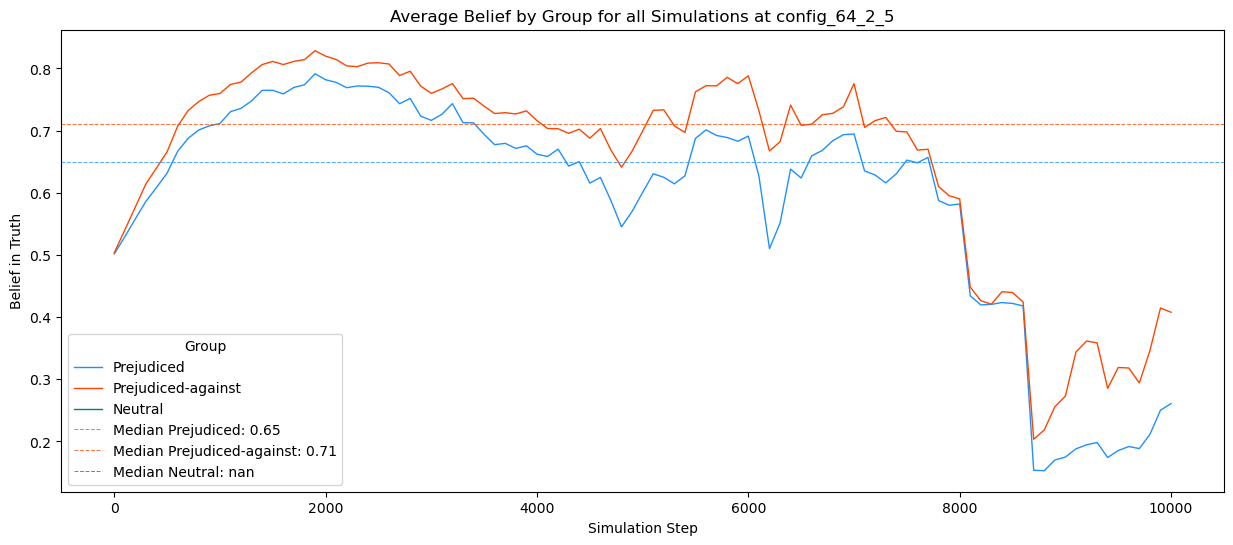

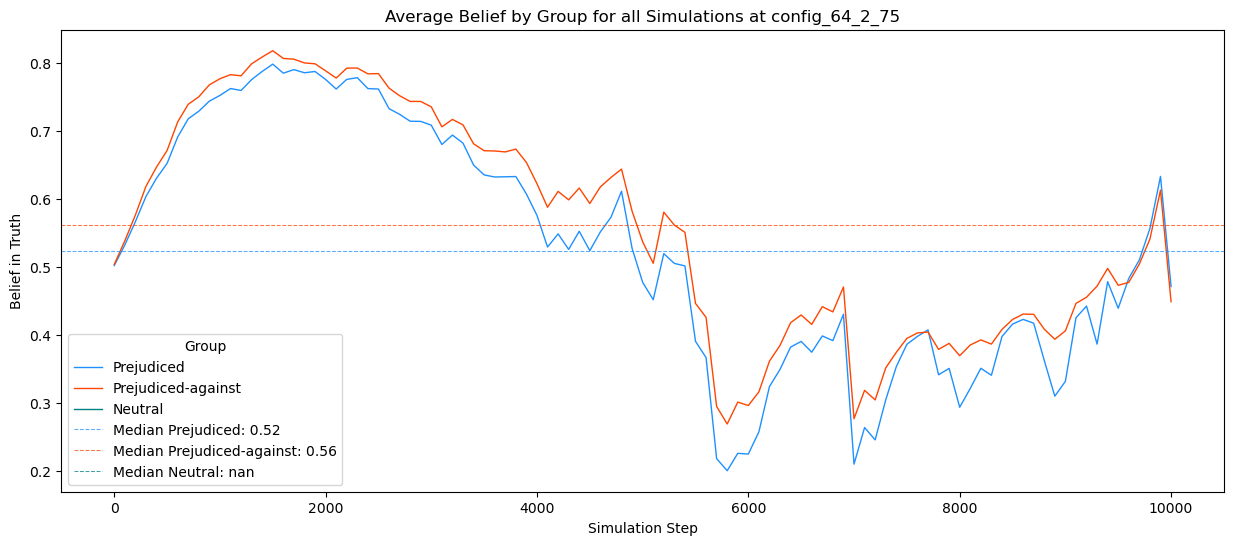

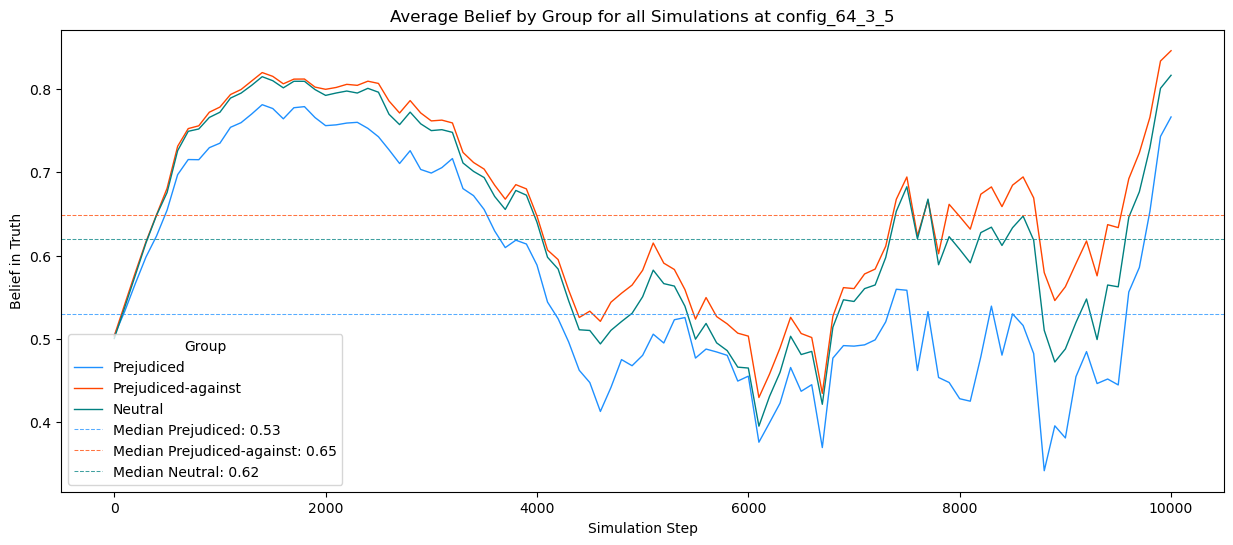

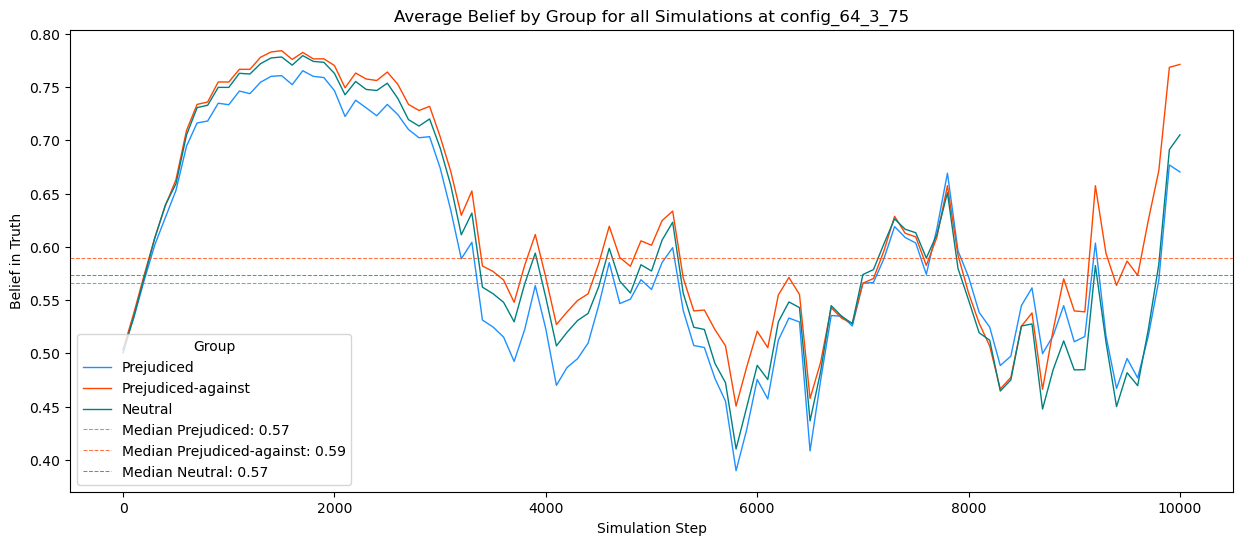

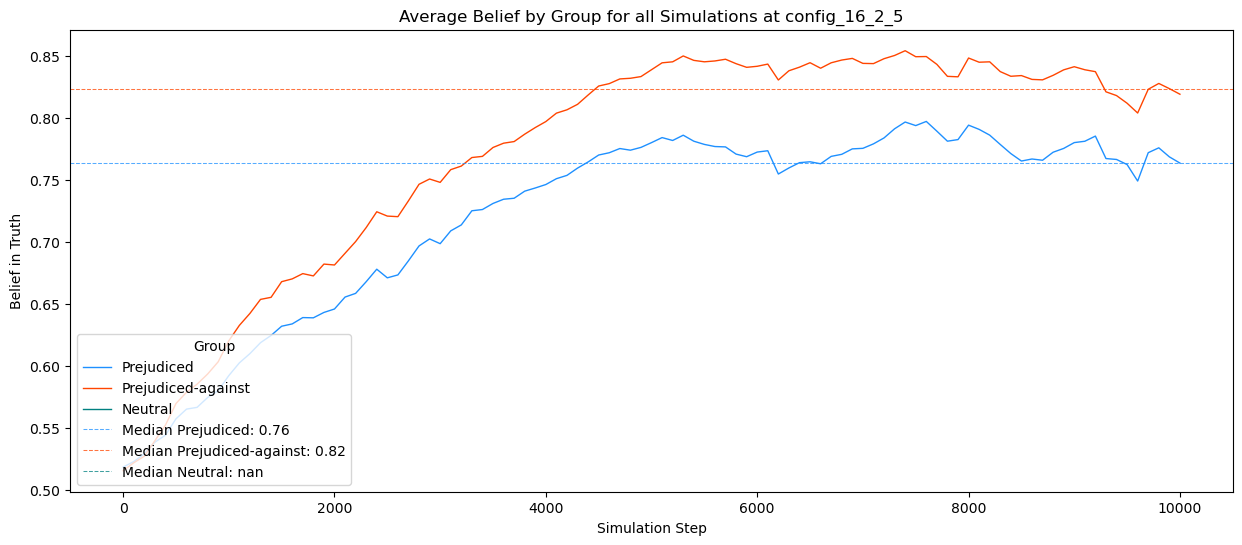

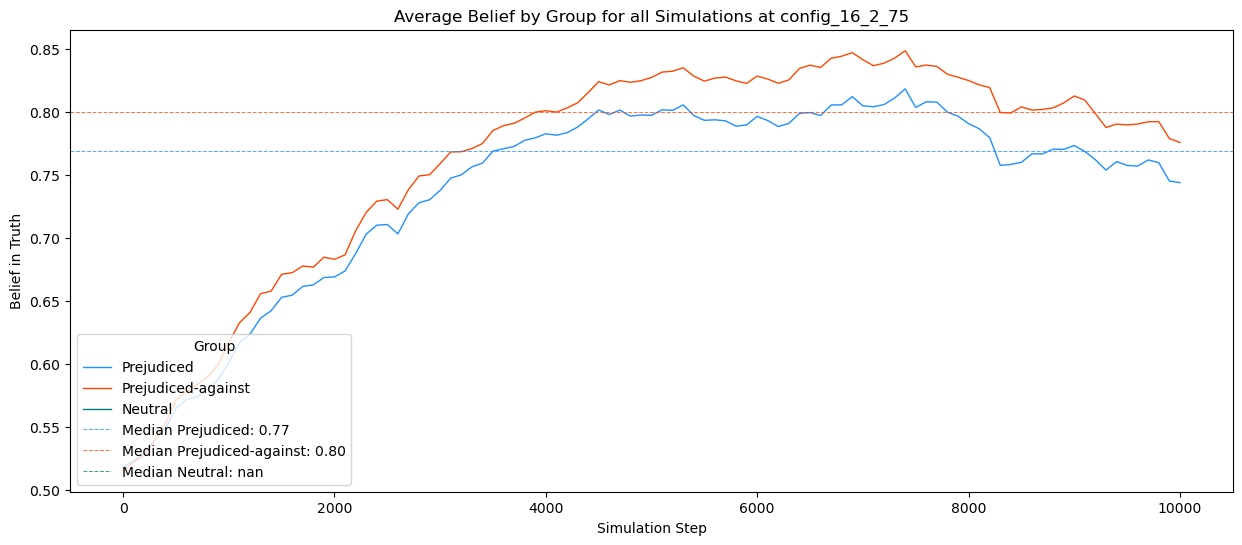

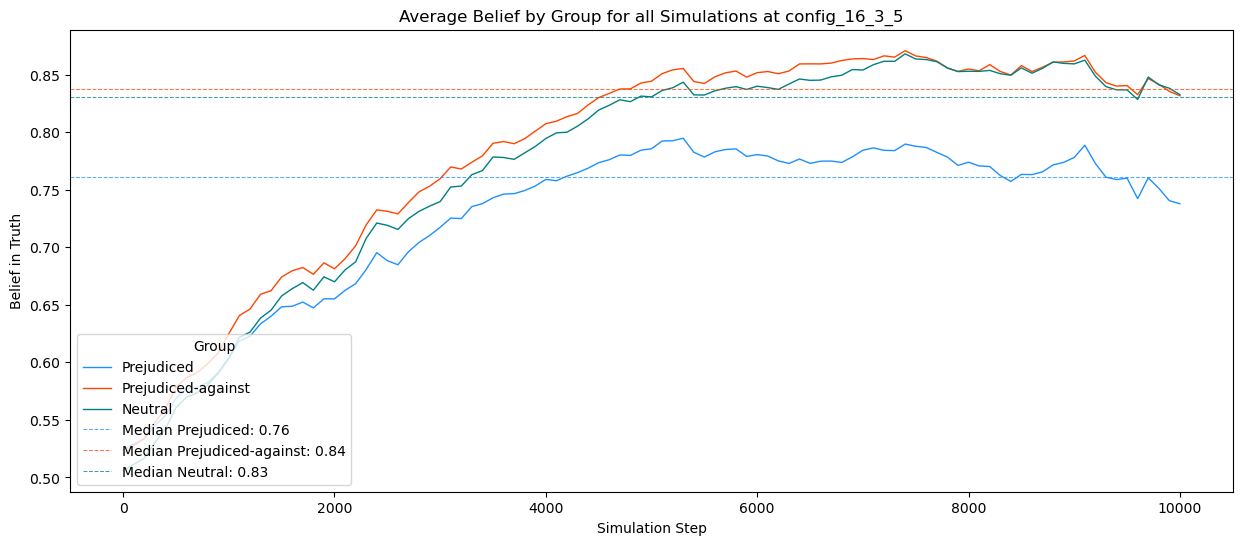

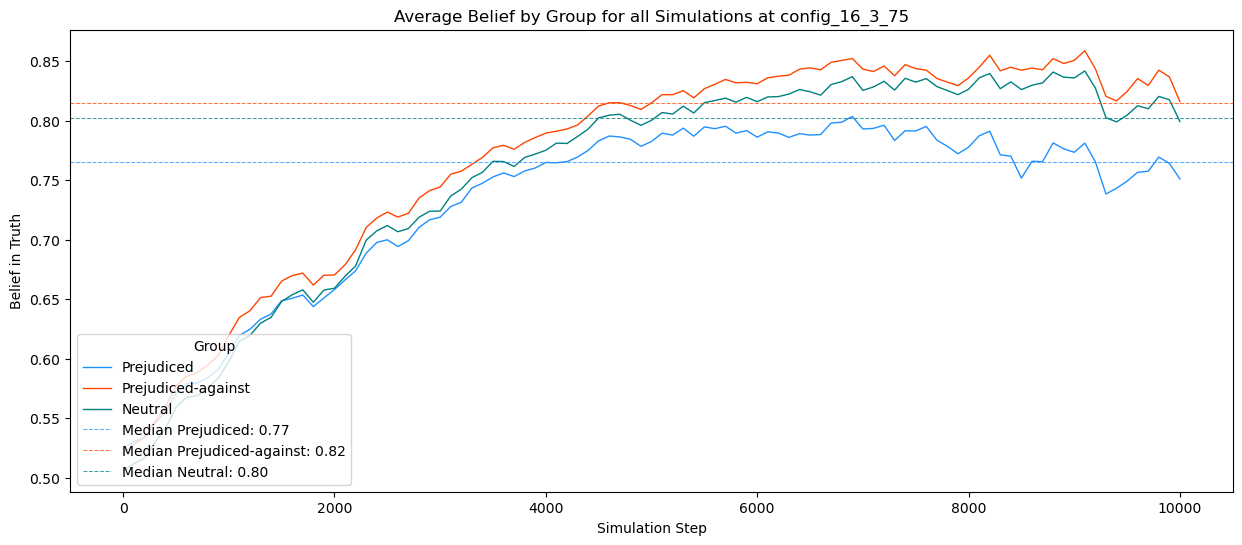

In [760]:
configs = [
    'config_64_2_5', 'config_64_2_75', 'config_64_3_5', 'config_64_3_75',
    'config_16_2_5', 'config_16_2_75', 'config_16_3_5', 'config_16_3_75'
]

for config in configs:
    avg_beliefs = aggregate_beliefs_by_config(eval(config), x)
    avg_beliefs_df = pd.DataFrame.from_dict(avg_beliefs, orient='index').T

    # Filter for rows where index modulo 100 equals 0
    # (This is because snapshots are taken every 100 steps, but also at the last step of every sim. We want to exclude these last steps, as they break the graph)
    avg_beliefs_df_filtered = avg_beliefs_df[avg_beliefs_df.index % 100 == 0]

    fig, ax = plt.subplots(figsize=(15, 6))
    
    ax.plot(avg_beliefs_df_filtered['prejudiced'], c="dodgerblue", lw=1, label="Prejudiced")
    ax.plot(avg_beliefs_df_filtered['prejudiced_against'], c="orangered", lw=1, label="Prejudiced-against")
    ax.plot(avg_beliefs_df_filtered['neutral'], c="teal", lw=1, label="Neutral")

    # Calculate and plot mean lines for each group
    median_prejudiced = avg_beliefs_df_filtered['prejudiced'].median()
    median_prejudiced_against = avg_beliefs_df_filtered['prejudiced_against'].median()
    median_neutral = avg_beliefs_df_filtered['neutral'].median()
    
    ax.axhline(median_prejudiced, color="dodgerblue", linestyle="--", alpha=0.75, lw=.75, label=f"Median Prejudiced: {median_prejudiced:.2f}")
    ax.axhline(median_prejudiced_against, color="orangered", linestyle="--", alpha=0.75, lw=.75, label=f"Median Prejudiced-against: {median_prejudiced_against:.2f}")
    ax.axhline(median_neutral, color="teal", linestyle="--", alpha=0.75, lw=.75, label=f"Median Neutral: {median_neutral:.2f}")

    ax.set_xlabel('Simulation Step')
    ax.set_ylabel('Belief in Truth')
    plt.legend(title='Group', loc='lower left')
    plt.title(f'Average Belief by Group for all Simulations at {config}')
    plt.show()

## Testing for statistically significant difference between average belief by group at each simulation step for each config

Wilcoxon Signed-Rank Test / Sign Test: 

Intervention: hypothetically converting the "prejudiced-against" group into the "prejudiced" group

Pairs: average belief at a given simulation step

Null Hypothesis: There is no significant difference in average belief between the "prejudiced-against" group and the "prejudiced" group at each simulation step.


Config: config_64_2_5 P-value: 2.6651409486700556e-18


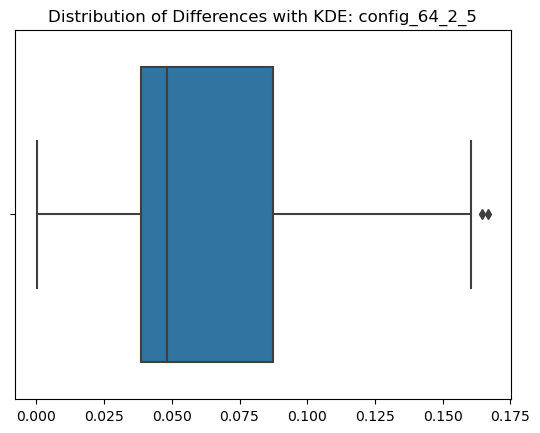

Config: config_64_2_75 P-value: 4.6093399392972235e-17


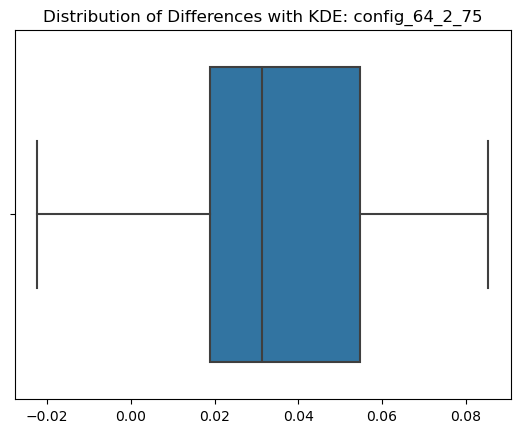

Config: config_64_3_5 P-value: 2.7461134254418407e-18


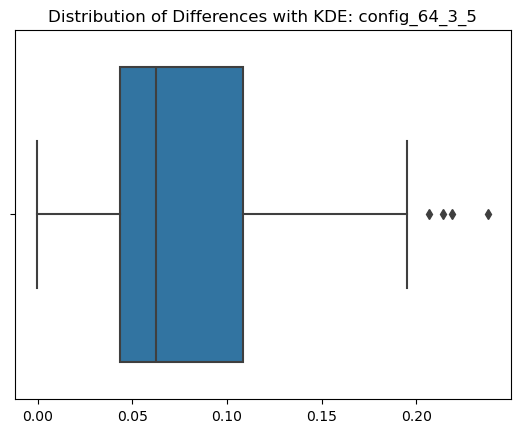

Config: config_64_3_75 P-value: 2.2751050597472828e-14


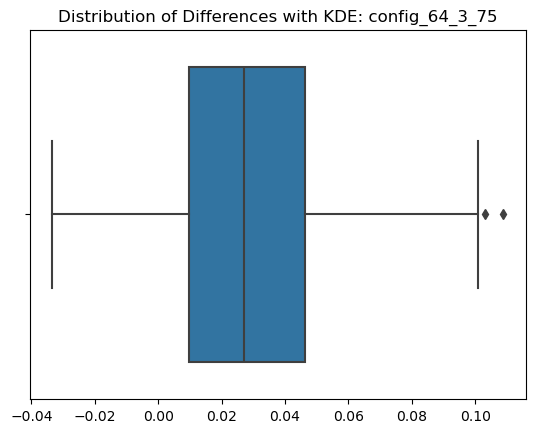

Config: config_16_2_5 P-value: 3.3850777705734153e-18


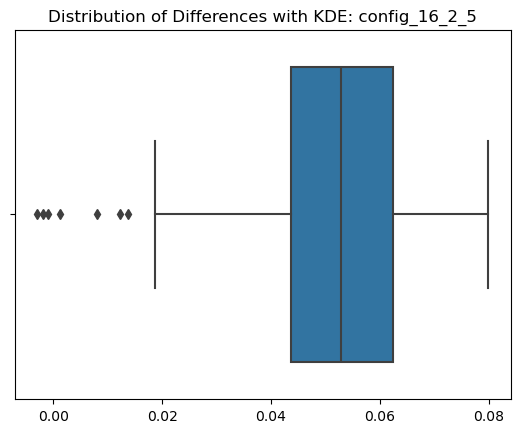

Config: config_16_2_75 P-value: 3.593201222799531e-18


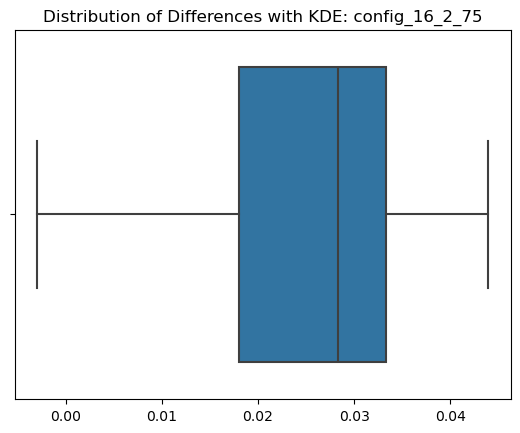

Config: config_16_3_5 P-value: 3.1888645425071274e-18


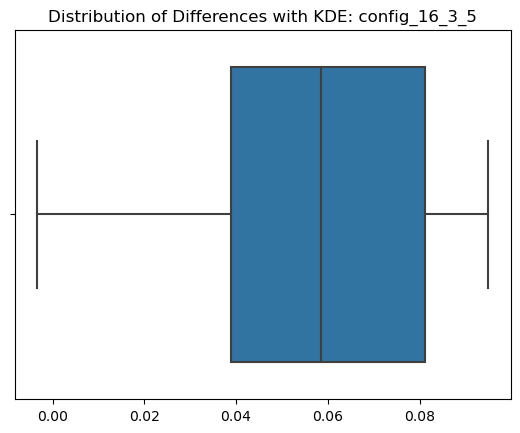

Config: config_16_3_75 P-value: 3.3850777705734153e-18


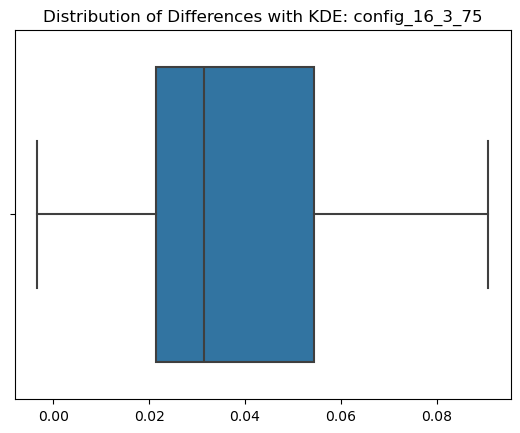

In [740]:
for config in configs:
    # Aggregate beliefs by config
    avg_beliefs = aggregate_beliefs_by_config(eval(config), x)
    avg_beliefs_df = pd.DataFrame.from_dict(avg_beliefs, orient='index').T

    # Drop the 'neutral' column
    avg_beliefs_df = avg_beliefs_df.drop(columns=['neutral'])

    # Filter for rows where index modulo 100 equals 0
    avg_beliefs_df_filtered = avg_beliefs_df[avg_beliefs_df.index % 100 == 0]

    # Perform the Wilcoxon signed-rank test on the filtered data
    w_stat, p_value_wilcoxon = stats.wilcoxon(avg_beliefs_df_filtered['prejudiced_against'], avg_beliefs_df_filtered['prejudiced'])

    # Store the results
    #results[config] = p_value_wilcoxon

    # Grab differences to test assumption (symmetrical distribution of differences)
    differences = avg_beliefs_df_filtered['prejudiced_against'] - avg_beliefs_df_filtered['prejudiced']

    print('Config:',config,'P-value:',p_value_wilcoxon)
    sns.boxplot(x=differences)
    plt.title(f'Distribution of Differences with KDE: {config}')
    plt.show()


The data fails the assumption of the Wilcoxon Signed-Rank Test. I am going to run a Sign Test, instead.

In [814]:
sign_test_results = []

for config in configs:
    # Aggregate beliefs by config
    avg_beliefs = aggregate_beliefs_by_config(eval(config), x)
    avg_beliefs_df = pd.DataFrame.from_dict(avg_beliefs, orient='index').T

    # Filter for rows where index modulo 100 equals 0
    avg_beliefs_df_filtered = avg_beliefs_df[avg_beliefs_df.index % 100 == 0]

    # Grab differences to test assumption (symmetrical distribution of differences)
    differences = avg_beliefs_df_filtered['prejudiced_against'] - avg_beliefs_df_filtered['prejudiced']

    # Calculate the number of positive and negative differences
    n_pos = np.sum(differences > 0)
    n_neg = np.sum(differences < 0)
    
    # We use neg if alternative is less, or pos if greater (not the minimum, as used for a two-sided test)
    n = n_neg
    
    # Calculate p-value using the binomial test
    binom_results = stats.binomtest(n, n=n_pos + n_neg, alternative='less')

    #print('Config:',config,'Results:',binom_results)

    # Append results to the list
    sign_test_results.append({
        'Config': config,
        'k': binom_results.k,
        'n': binom_results.n,
        'Statistic': binom_results.statistic,
        'p-value': binom_results.pvalue
    })

# Convert the list to a DataFrame
sign_test_results_df = pd.DataFrame(sign_test_results)

# Format, and color row where p > 0.001
colored_st_results = sign_test_results_df.style.format(
    {'Statistic': "{:.2f}", 'p-value': "{:.2}"}
).apply(
    lambda row: ['background-color: maroon' if row['p-value'] > 0.001 else 'background-color: black' for _ in row],
    axis=1
).set_caption("Binomial Test Results")

# Display the styled DataFrame
colored_st_results


,Config,k,n,Statistic,p-value
0,config_64_2_5,0,101,0.00,3.9e-31
1,config_64_2_75,5,101,0.05,3.3e-23
2,config_64_3_5,2,101,0.02,2e-27
3,config_64_3_75,1,101,0.01,4e-29
4,config_16_2_5,3,101,0.03,6.8e-26
5,config_16_2_75,0,101,0.00,3.9e-31
6,config_16_3_5,4,101,0.04,1.7e-24
7,config_16_3_75,0,101,0.00,3.9e-31


The test refutes the null hypothesis at every simulation configuration. The alternative hypothesis is set to less, which indicates that, indeed, prejudiced nodes believe in the truth less than the nodes that they are prejudiced against, by a statistically significant amount.

Below, I run the same test to check for a statistically significant difference between prejudiced-against nodes and neutral nodes.

In [828]:
sign_test_results = []

# Re-defining configs to only include simulations with 3 groups, as only those simulations contain neutral nodes
configs_3 = [
    'config_64_3_5', 'config_64_3_75',
    'config_16_3_5', 'config_16_3_75'
]

for config in configs_3:
    # Aggregate beliefs by config
    avg_beliefs = aggregate_beliefs_by_config(eval(config), x)
    avg_beliefs_df = pd.DataFrame.from_dict(avg_beliefs, orient='index').T

    # Filter for rows where index modulo 100 equals 0
    avg_beliefs_df_filtered = avg_beliefs_df[avg_beliefs_df.index % 100 == 0]

    # Grab differences to test assumption (symmetrical distribution of differences)
    differences = avg_beliefs_df_filtered['prejudiced_against'] - avg_beliefs_df_filtered['neutral']

    # Calculate the number of positive and negative differences
    n_pos = np.sum(differences > 0)
    n_neg = np.sum(differences < 0)
    
    # We use neg if alternative is less, or pos if greater (not the minimum, as used for a two-sided test)
    n = n_neg
    
    # Calculate p-value using the binomial test
    binom_results = stats.binomtest(n, n=n_pos + n_neg, alternative='less')

    #print('Config:',config,'Results:',binom_results)

    # Append results to the list
    sign_test_results.append({
        'Config': config,
        'k': binom_results.k,
        'n': binom_results.n,
        'Statistic': binom_results.statistic,
        'p-value': binom_results.pvalue
    })

# Convert the list to a DataFrame
sign_test_results_df = pd.DataFrame(sign_test_results)

# Format, and color row where p > 0.001
colored_st_results = sign_test_results_df.style.format(
    {'Statistic': "{:.2f}", 'p-value': "{:.2}"}
).apply(
    lambda row: ['background-color: maroon' if row['p-value'] > 0.001 else 'background-color: black' for _ in row],
    axis=1
).set_caption("Binomial Test Results")

# Display the styled DataFrame
colored_st_results

,Config,k,n,Statistic,p-value
0,config_64_3_5,61,76,0.80,1.0
1,config_64_3_75,21,101,0.21,1.4e-09
2,config_16_3_5,70,101,0.69,1.0
3,config_16_3_75,12,101,0.12,5.4e-16


Strangely, the p-values again indicate that there is a statistically significant difference between the beliefs of prejudiced-against and neutral nodes. I know that the test is working, as in setting the alternative hypothesis to greater, the p-value is 1.0 at every config. This lines up with what I'm seeing visually–– indeed the teal line consistently runs between the orange and blue lines.

I am going to run more simulations to check this.

# Loading new data (Same configs, different seeds, steps extended to 20,000)

In [832]:
x2 = Processor("data2")
x2.add_config("network.groups", "mistrust", "seed")

x2c = Processor("data2_control")
x2c.add_config("network.groups", "mistrust", "seed")

In [861]:
# Define configurations
configurations = {
    '64_2_0.5': (64, 2, 0.5),
    '64_2_0.75': (64, 2, 0.75),
    '64_3_0.5': (64, 3, 0.5),
    '64_3_0.75': (64, 3, 0.75),
    '16_2_0.5': (16, 2, 0.5),
    '16_2_0.75': (16, 2, 0.75),
    '16_3_0.5': (16, 3, 0.5),
    '16_3_0.75': (16, 3, 0.75)
}

config_indices = {config: [] for config in configurations.keys()}

# Populate dict with indices of those sims that were generated at given config
for idx, row in x2.get().iterrows():
    for config, (network_size, network_groups, mistrust) in configurations.items():
        if (row['network_size'] == network_size and 
            row['network_groups'] == network_groups and 
            row['mistrust'] == mistrust):
            config_indices[config].append(idx)

# Separate by key
config_64_2_5 = config_indices['64_2_0.5']
config_64_2_75 = config_indices['64_2_0.75']
config_64_3_5 = config_indices['64_3_0.5']
config_64_3_75 = config_indices['64_3_0.75']
config_16_2_5 = config_indices['16_2_0.5']
config_16_2_75 = config_indices['16_2_0.75']
config_16_3_5 = config_indices['16_3_0.5']
config_16_3_75 = config_indices['16_3_0.75']

In [862]:
# Define configurations for control group

control_configurations = {
    '64_2_1': (64, 2, 1),
    '64_3_1': (64, 3, 1),
    '16_2_1': (16, 2, 1),
    '16_3_1': (16, 3, 1),
}

control_config_indices = {config: [] for config in control_configurations.keys()}

# Populate dict with indices of those sims that were generated at given config
for idx, row in x2c.get().iterrows():
    for config, (network_size, network_groups, mistrust) in control_configurations.items():
        if (row['network_size'] == network_size and 
            row['network_groups'] == network_groups and 
            row['mistrust'] == mistrust):
            control_config_indices[config].append(idx)

# Separate by key
config_64_2_1 = control_config_indices['64_2_1']
config_64_3_1 = control_config_indices['64_3_1']
config_16_2_1 = control_config_indices['16_2_1']
config_16_3_1 = control_config_indices['16_3_1']


In [834]:
configs = [
    'config_64_2_5', 'config_64_2_75', 'config_64_3_5', 'config_64_3_75',
    'config_16_2_5', 'config_16_2_75', 'config_16_3_5', 'config_16_3_75'
]

for config in configs:
    avg_beliefs = aggregate_beliefs_by_config(eval(config), x2)
    avg_beliefs_df = pd.DataFrame.from_dict(avg_beliefs, orient='index').T

    # Filter for rows where index modulo 100 equals 0
    avg_beliefs_df_filtered = avg_beliefs_df[avg_beliefs_df.index % 100 == 0]

    # fig, ax = plt.subplots(figsize=(15, 6))
    
    # ax.plot(avg_beliefs_df_filtered['prejudiced'], c="dodgerblue", lw=1, label="Prejudiced")
    # ax.plot(avg_beliefs_df_filtered['prejudiced_against'], c="orangered", lw=1, label="Prejudiced-against")
    # ax.plot(avg_beliefs_df_filtered['neutral'], c="teal", lw=1, label="Neutral")

    # # Calculate and plot mean lines for each group
    # median_prejudiced = avg_beliefs_df_filtered['prejudiced'].median()
    # median_prejudiced_against = avg_beliefs_df_filtered['prejudiced_against'].median()
    # median_neutral = avg_beliefs_df_filtered['neutral'].median()
    
    # ax.axhline(median_prejudiced, color="dodgerblue", linestyle="--", alpha=0.75, lw=1, label=f"Median Prejudiced: {median_prejudiced:.2f}")
    # ax.axhline(median_prejudiced_against, color="orangered", linestyle="-.", alpha=0.75, lw=1, label=f"Median Prejudiced-against: {median_prejudiced_against:.2f}")
    # ax.axhline(median_neutral, color="teal", linestyle=":", alpha=0.75, lw=1, label=f"Median Neutral: {median_neutral:.2f}")

    # ax.set_xlabel('Simulation Step')
    # ax.set_ylabel('Belief in Truth')
    # plt.legend(title='Group', loc='lower left')
    # plt.title(f'Average Belief by Group for all Simulations at {config}')
    # plt.show()

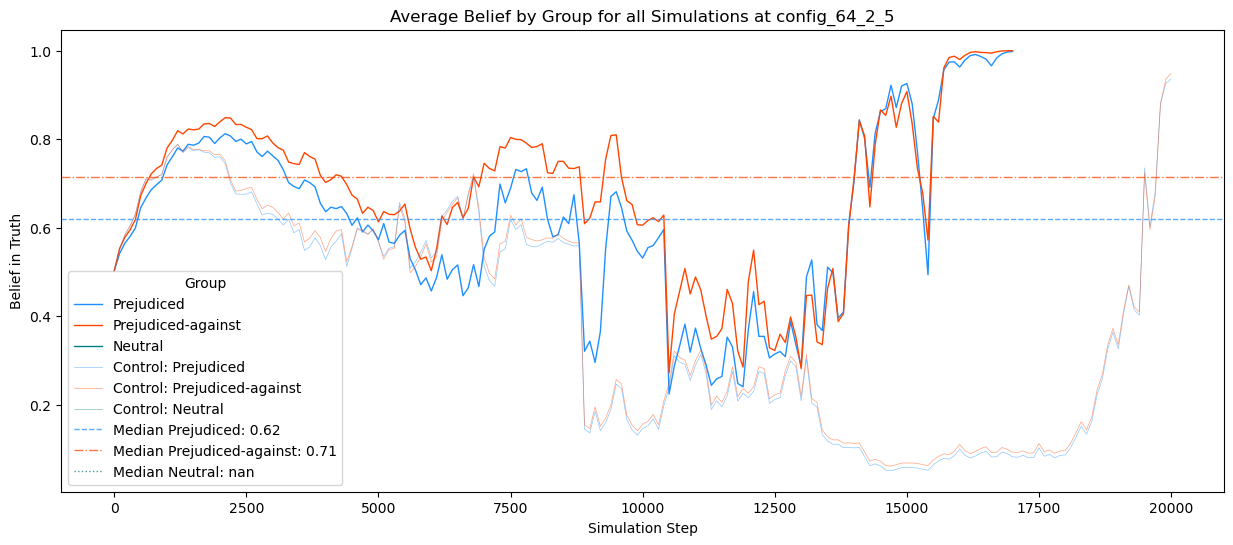

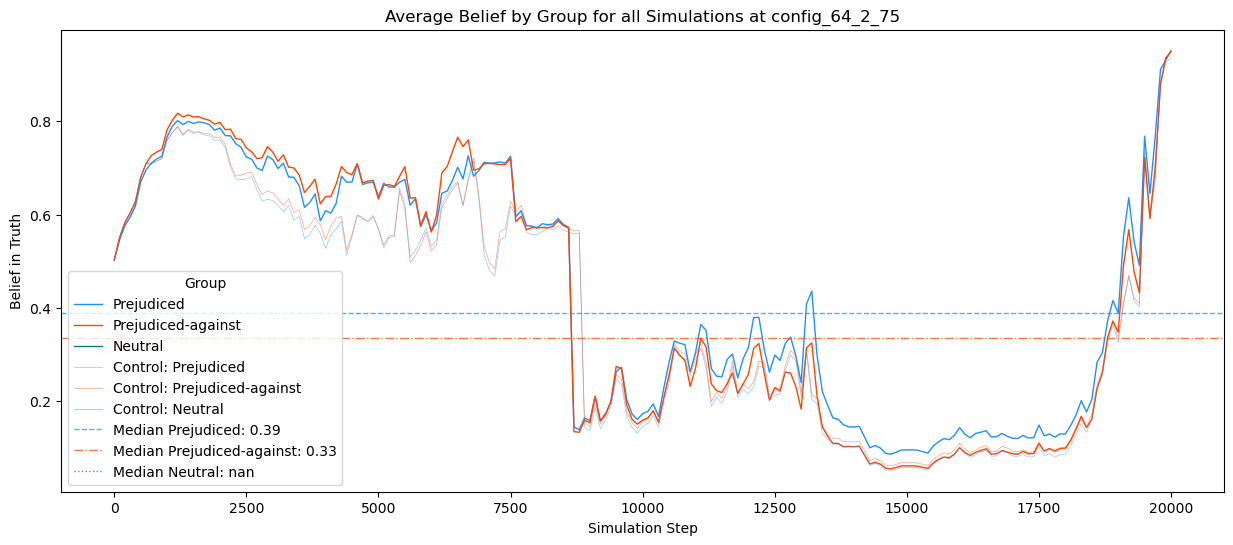

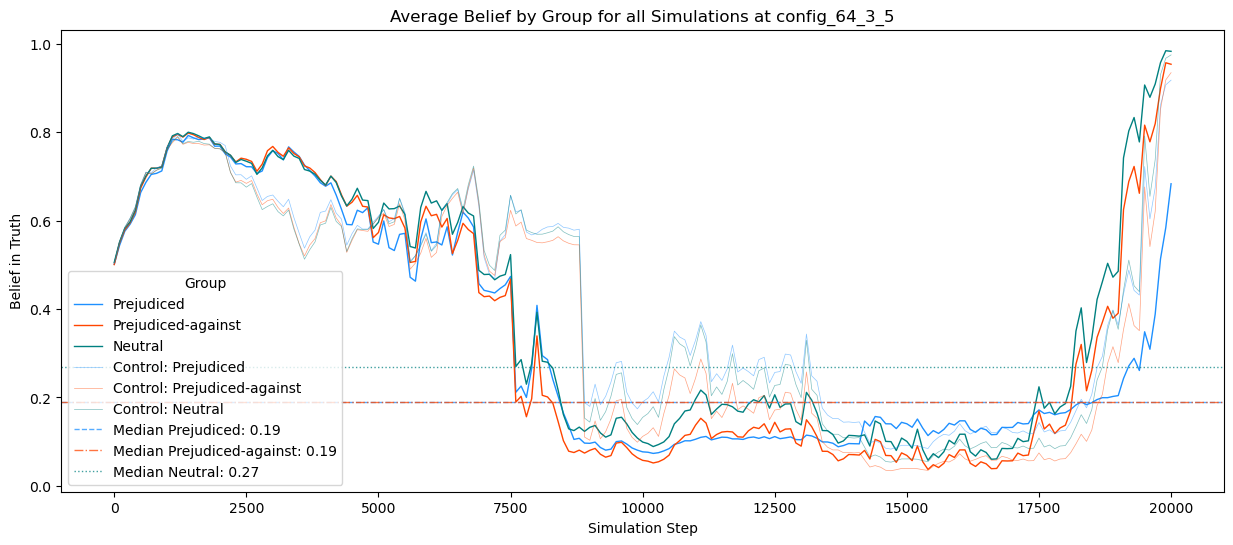

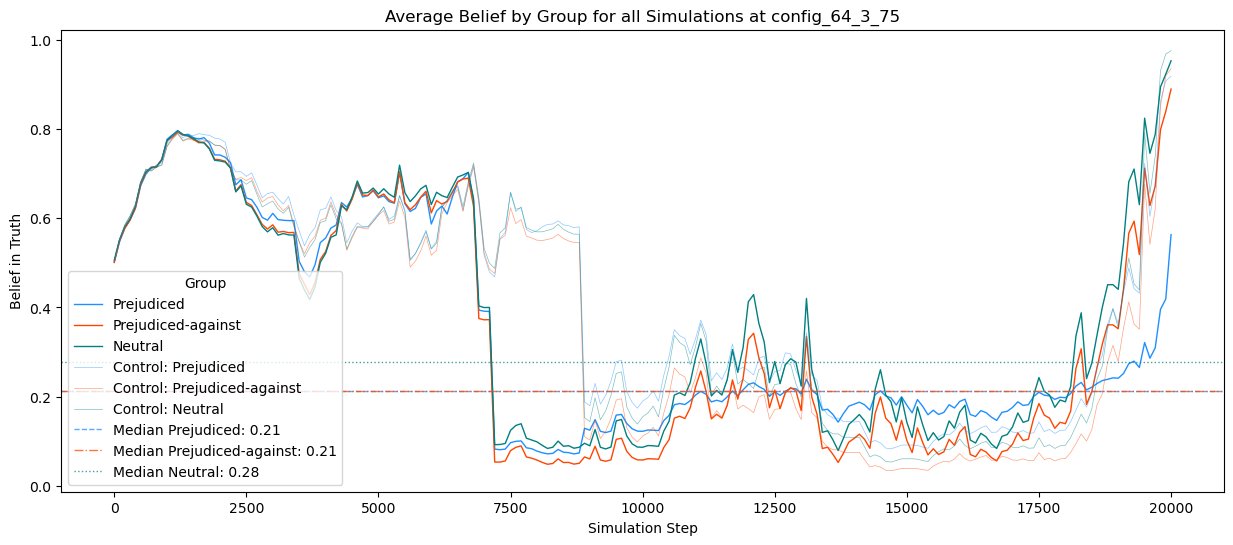

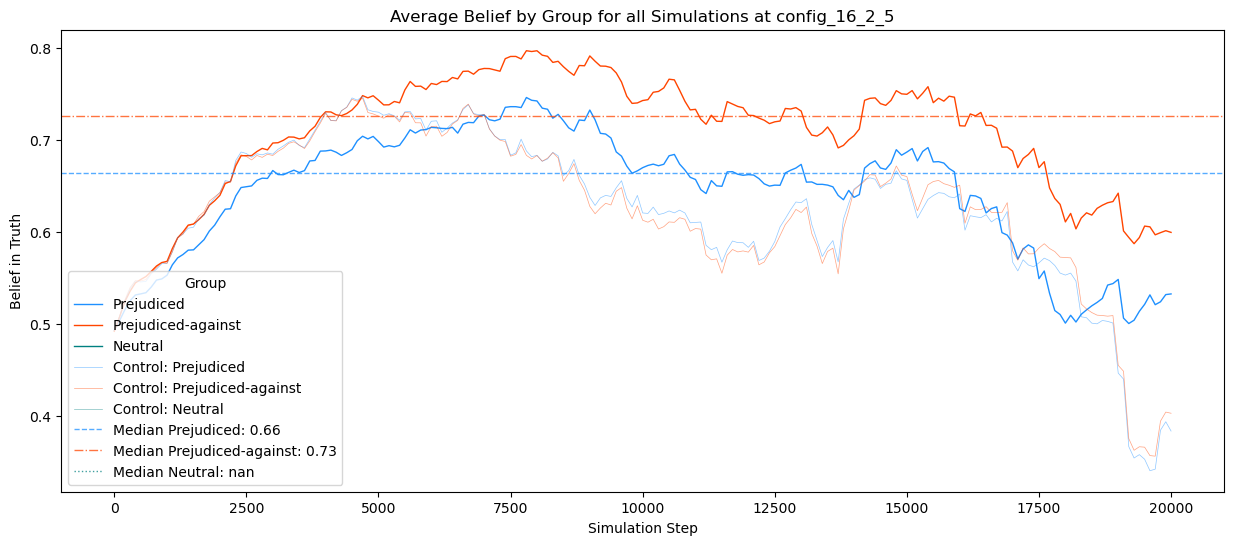

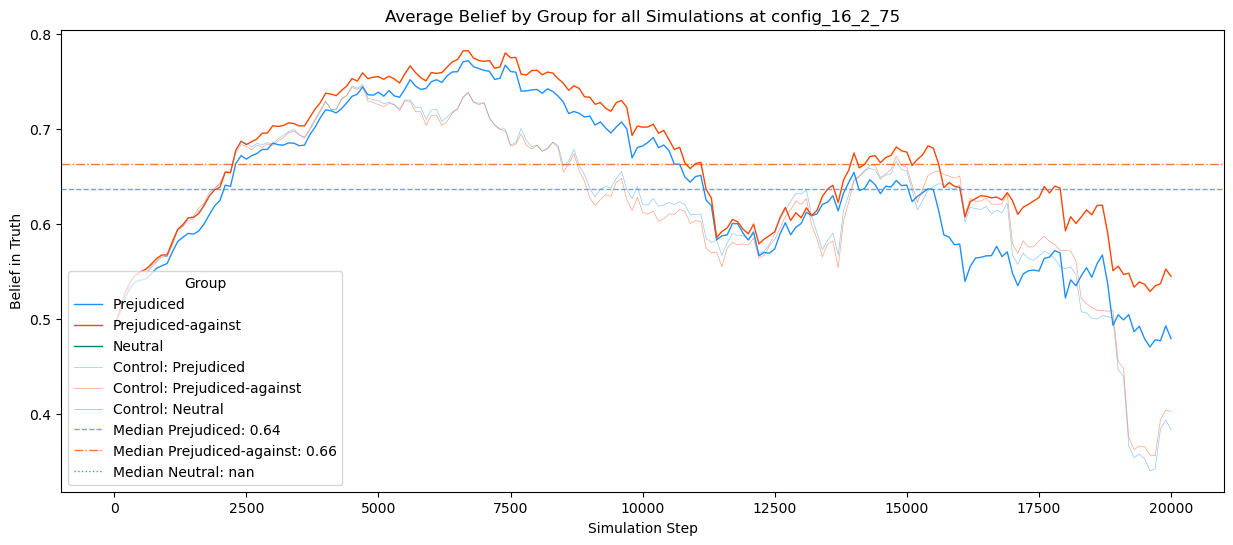

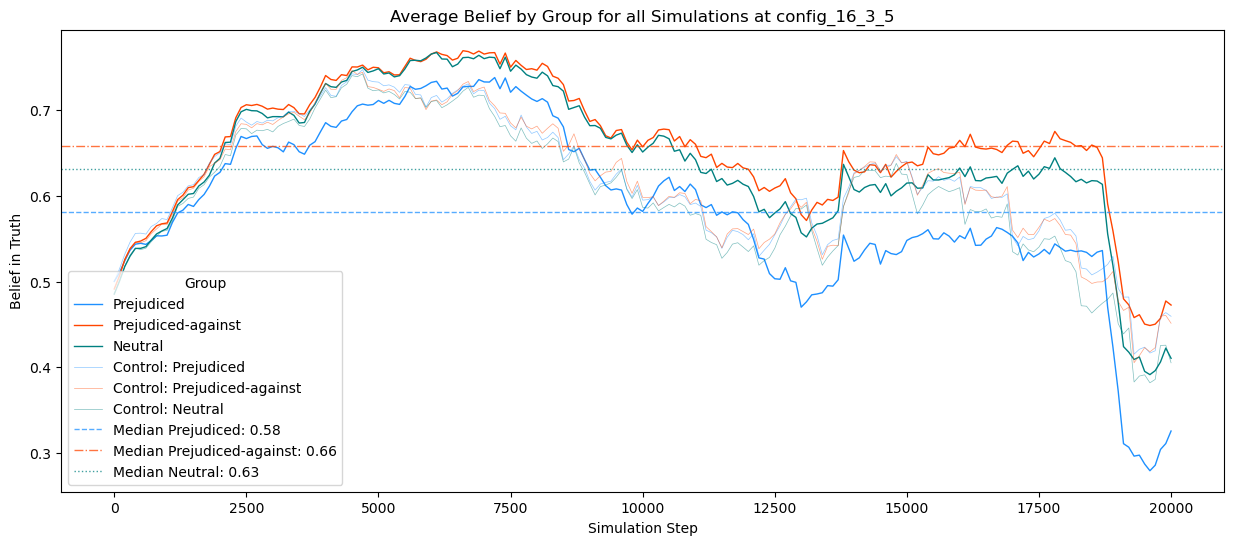

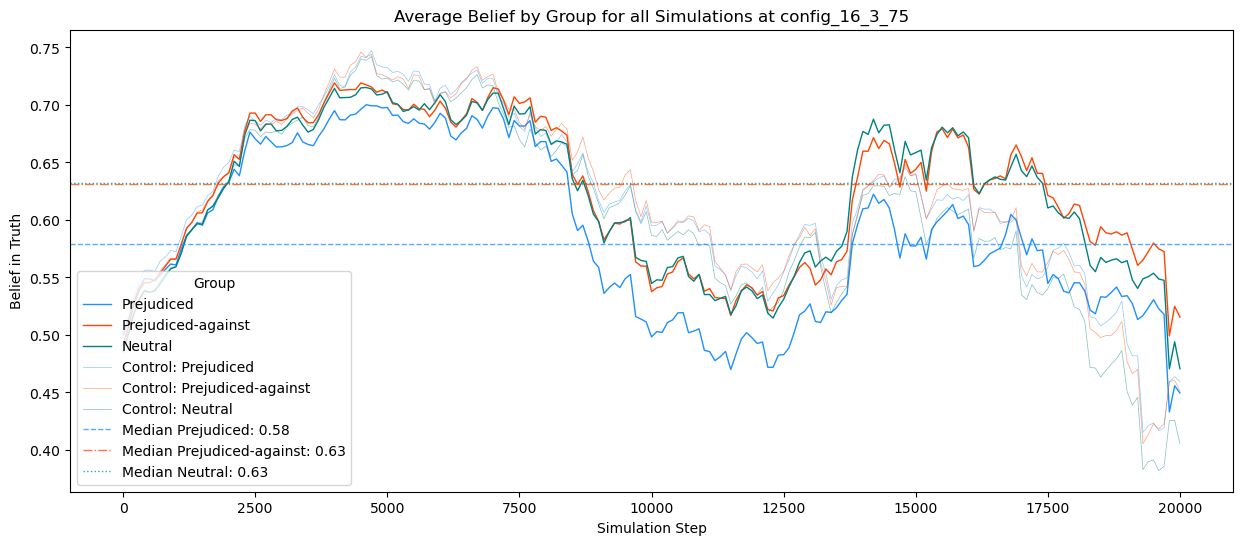

In [870]:
configs = [
    'config_64_2_5', 'config_64_2_75', 'config_64_3_5', 'config_64_3_75',
    'config_16_2_5', 'config_16_2_75', 'config_16_3_5', 'config_16_3_75'
]

control_configs = [
    'config_64_2_1', 'config_64_2_1', 'config_64_3_1', 'config_64_3_1',
    'config_16_2_1', 'config_16_2_1', 'config_16_3_1', 'config_16_3_1'
]

for i, config in enumerate(configs):
    control_config = control_configs[i]
    
    # Aggregate beliefs for the experimental configuration
    avg_beliefs = aggregate_beliefs_by_config(eval(config), x2)
    avg_beliefs_df = pd.DataFrame.from_dict(avg_beliefs, orient='index').T
    
    # Aggregate beliefs for the control configuration
    avg_beliefs_control = aggregate_beliefs_by_config(eval(control_config), x2c)
    avg_beliefs_df_control = pd.DataFrame.from_dict(avg_beliefs_control, orient='index').T
    
    # Filter for rows where index modulo 100 equals 0
    avg_beliefs_df_filtered = avg_beliefs_df[avg_beliefs_df.index % 100 == 0]
    avg_beliefs_df_control_filtered = avg_beliefs_df_control[avg_beliefs_df_control.index % 100 == 0]

    fig, ax = plt.subplots(figsize=(15, 6))

    # Plot experiment groups
    ax.plot(avg_beliefs_df_filtered['prejudiced'], c="dodgerblue", lw=1, label="Prejudiced")
    ax.plot(avg_beliefs_df_filtered['prejudiced_against'], c="orangered", lw=1, label="Prejudiced-against")
    ax.plot(avg_beliefs_df_filtered['neutral'], c="teal", lw=1, label="Neutral")

    # Plot control groups
    ax.plot(avg_beliefs_df_control_filtered['prejudiced'], c="dodgerblue", lw=0.5, alpha=0.5, label="Control: Prejudiced")
    ax.plot(avg_beliefs_df_control_filtered['prejudiced_against'], c="orangered", lw=0.5, alpha=0.5, label="Control: Prejudiced-against")
    ax.plot(avg_beliefs_df_control_filtered['neutral'], c="teal", lw=0.5, alpha=0.5, label="Control: Neutral")


    # Calculate and plot mean lines for each group
    median_prejudiced = avg_beliefs_df_filtered['prejudiced'].median()
    median_prejudiced_against = avg_beliefs_df_filtered['prejudiced_against'].median()
    median_neutral = avg_beliefs_df_filtered['neutral'].median()
    
    ax.axhline(median_prejudiced, color="dodgerblue", linestyle="--", alpha=0.75, lw=1, label=f"Median Prejudiced: {median_prejudiced:.2f}")
    ax.axhline(median_prejudiced_against, color="orangered", linestyle="-.", alpha=0.75, lw=1, label=f"Median Prejudiced-against: {median_prejudiced_against:.2f}")
    ax.axhline(median_neutral, color="teal", linestyle=":", alpha=0.75, lw=1, label=f"Median Neutral: {median_neutral:.2f}")

    ax.set_xlabel('Simulation Step')
    ax.set_ylabel('Belief in Truth')
    plt.legend(title='Group', loc='lower left')
    plt.title(f'Average Belief by Group for all Simulations at {config}')
    plt.show()

In [844]:
control_configs = [
    'config_64_2_1', 'config_64_2_1', 'config_64_3_1', 'config_64_3_1',
    'config_16_2_1', 'config_16_2_1', 'config_16_3_1', 'config_16_3_1'
]

for config in control_configs:
    avg_beliefs = aggregate_beliefs_by_config(eval(config), x2c)
    avg_beliefs_df = pd.DataFrame.from_dict(avg_beliefs, orient='index').T

    # Filter for rows where index modulo 100 equals 0
    avg_beliefs_df_filtered = avg_beliefs_df[avg_beliefs_df.index % 100 == 0]

    fig, ax = plt.subplots(figsize=(15, 6))
    
    ax.plot(avg_beliefs_df_filtered['prejudiced'], c="dodgerblue", lw=1, label="Prejudiced")
    ax.plot(avg_beliefs_df_filtered['prejudiced_against'], c="orangered", lw=1, label="Prejudiced-against")
    ax.plot(avg_beliefs_df_filtered['neutral'], c="teal", lw=1, label="Neutral")

    # Calculate and plot mean lines for each group
    median_prejudiced = avg_beliefs_df_filtered['prejudiced'].median()
    median_prejudiced_against = avg_beliefs_df_filtered['prejudiced_against'].median()
    median_neutral = avg_beliefs_df_filtered['neutral'].median()
    
    ax.axhline(median_prejudiced, color="dodgerblue", linestyle="--", alpha=0.75, lw=1, label=f"Median Prejudiced: {median_prejudiced:.2f}")
    ax.axhline(median_prejudiced_against, color="orangered", linestyle="-.", alpha=0.75, lw=1, label=f"Median Prejudiced-against: {median_prejudiced_against:.2f}")
    ax.axhline(median_neutral, color="teal", linestyle=":", alpha=0.75, lw=1, label=f"Median Neutral: {median_neutral:.2f}")

    ax.set_xlabel('Simulation Step')
    ax.set_ylabel('Belief in Truth')
    plt.legend(title='Group', loc='lower left')
    plt.title(f'Average Belief by Group for all Simulations at {config}')
    plt.show()

IndexError: single positional indexer is out-of-bounds

In [831]:
# Sign Test for new data
# Null Hypothesis: There is no significant difference in average belief between the "prejudiced-against" group and the "prejudiced" group at each simulation step.
# Alternative Hypothesis: 
# The average belief of the prejudiced group is less than the average belief of the prejudiced-against group, over each simulation step, to a statistically significant extent.

sign_test_results = []

for config in configs:
    # Aggregate beliefs by config
    avg_beliefs = aggregate_beliefs_by_config(eval(config), x2)
    avg_beliefs_df = pd.DataFrame.from_dict(avg_beliefs, orient='index').T

    # Filter for rows where index modulo 100 equals 0
    avg_beliefs_df_filtered = avg_beliefs_df[avg_beliefs_df.index % 100 == 0]

    # Grab differences
    differences = avg_beliefs_df_filtered['prejudiced_against'] - avg_beliefs_df_filtered['prejudiced']

    # Calculate the number of positive and negative differences
    n_pos = np.sum(differences > 0)
    n_neg = np.sum(differences < 0)
    
    # We use neg if alternative is less, or pos if greater (not the minimum, as used for a two-sided test)
    n = n_neg
    
    # Calculate p-value using the binomial test
    binom_results = stats.binomtest(n, n=n_pos + n_neg, alternative='greater')

    #print('Config:',config,'Results:',binom_results)

    # Append results to the list
    sign_test_results.append({
        'Config': config,
        'k': binom_results.k,
        'n': binom_results.n,
        'Statistic': binom_results.statistic,
        'p-value': binom_results.pvalue
    })

# Convert the list to a DataFrame
sign_test_results_df = pd.DataFrame(sign_test_results)

# Format, and color row where p > 0.001
colored_st_results = sign_test_results_df.style.format(
    {'Statistic': "{:.2f}", 'p-value': "{:.2}"}
).apply(
    lambda row: ['background-color: maroon' if row['p-value'] > 0.001 else 'background-color: black' for _ in row],
    axis=1
).set_caption("Binomial Test Results")

# Display the styled DataFrame
colored_st_results


,Config,k,n,Statistic,p-value
0,config_64_2_5,21,171,0.12,1.0
1,config_64_2_75,129,201,0.64,3.5e-05
2,config_64_3_5,98,201,0.49,0.66
3,config_64_3_75,146,201,0.73,5.2e-11
4,config_16_2_5,1,201,0.00,1.0
5,config_16_2_75,2,201,0.01,1.0
6,config_16_3_5,2,201,0.01,1.0
7,config_16_3_75,6,201,0.03,1.0


I need to check this against a control of prejudiced_certainty = 1. 

It is strange that at size 64, 3 groups, 0.5 certainty, prejudiced nodes are better off than they are at 64, 3 groups, 075 certainty, relative to the nodes that they are prejudiced against. 

Considering that, it is due to the increase in prejudice that there is less disparity between prejudiced and non-prejudiced groups at around step 12,500:

It seems like prejudiced nodes are better off, epistemically, at config 64_3_5 than they are at config 64_3_75 due to their increased capcity to sway the whole network towards a credence that owes its magnitude to testimonial injustice. 

In [829]:
# Checking to see if neutral nodes still perform epistemically worse than prejudiced against nodes:
configs_3 = [
    'config_64_3_5', 'config_64_3_75',
    'config_16_3_5', 'config_16_3_75'
]

sign_test_results = []

for config in configs_3:
    # Aggregate beliefs by config
    avg_beliefs = aggregate_beliefs_by_config(eval(config), x2)
    avg_beliefs_df = pd.DataFrame.from_dict(avg_beliefs, orient='index').T

    # Filter for rows where index modulo 100 equals 0
    avg_beliefs_df_filtered = avg_beliefs_df[avg_beliefs_df.index % 100 == 0]

    # Grab differences to test assumption (symmetrical distribution of differences)
    differences = avg_beliefs_df_filtered['prejudiced_against'] - avg_beliefs_df_filtered['neutral']

    # Calculate the number of positive and negative differences
    n_pos = np.sum(differences > 0)
    n_neg = np.sum(differences < 0)
    
    n = n_neg
    
    # Calculate p-value using the binomial test
    binom_results = stats.binomtest(n, n=n_pos + n_neg, alternative='less')

    # Append results to the list
    sign_test_results.append({
        'Config': config,
        'k': binom_results.k,
        'n': binom_results.n,
        'Statistic': binom_results.statistic,
        'p-value': binom_results.pvalue
    })

# Convert the list to a DataFrame
sign_test_results_df = pd.DataFrame(sign_test_results)

# Format, and color row where p > 0.001
colored_st_results = sign_test_results_df.style.format(
    {'Statistic': "{:.4f}", 'p-value': "{:.2}"}
).apply(
    lambda row: ['background-color: maroon' if row['p-value'] > 0.001 else 'background-color: black' for _ in row],
    axis=1
).set_caption("Binomial Test Results")

# Display the styled DataFrame
colored_st_results




,Config,k,n,Statistic,p-value
0,config_64_3_5,178,201,0.8856,1.0
1,config_64_3_75,171,201,0.8507,1.0
2,config_16_3_5,4,201,0.0199,2.1e-53
3,config_16_3_75,67,201,0.3333,1.3e-06


In [872]:
prop_df = x2.get()
prop_df['Converged/_total'] = (action_counts['B'] + action_counts['A']) / (action_counts['A'] + action_counts['B'] + action_counts['?'])

prop_df['Converged/_total']

0      0.63
1      0.73
2      0.71
3      0.75
4      0.98
5      0.98
6      0.97
7      0.98
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13      NaN
14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
19      NaN
20      NaN
21      NaN
22      NaN
23      NaN
24      NaN
25      NaN
26      NaN
27      NaN
28      NaN
29      NaN
30      NaN
31      NaN
32      NaN
33      NaN
34      NaN
35      NaN
36      NaN
37      NaN
38      NaN
39      NaN
40      NaN
41      NaN
42      NaN
43      NaN
44      NaN
45      NaN
46      NaN
47      NaN
48      NaN
49      NaN
50      NaN
51      NaN
52      NaN
53      NaN
54      NaN
55      NaN
56      NaN
57      NaN
58      NaN
59      NaN
60      NaN
61      NaN
62      NaN
63      NaN
64      NaN
65      NaN
66      NaN
67      NaN
68      NaN
69      NaN
70      NaN
71      NaN
72      NaN
73      NaN
74      NaN
75      NaN
76      NaN
77      NaN
78      NaN
79      NaN
80      NaN
81      NaN
82      NaN
83  